Hola **Tom**!

Soy **Patricio Requena** 👋. Es un placer ser el revisor de tu proyecto el día de hoy!

Revisaré tu proyecto detenidamente con el objetivo de ayudarte a mejorar y perfeccionar tus habilidades. Durante mi revisión, identificaré áreas donde puedas hacer mejoras en tu código, señalando específicamente qué y cómo podrías ajustar para optimizar el rendimiento y la claridad de tu proyecto. Además, es importante para mí destacar los aspectos que has manejado excepcionalmente bien. Reconocer tus fortalezas te ayudará a entender qué técnicas y métodos están funcionando a tu favor y cómo puedes aplicarlos en futuras tareas. 

_**Recuerda que al final de este notebook encontrarás un comentario general de mi parte**_, empecemos!

Encontrarás mis comentarios dentro de cajas verdes, amarillas o rojas, ⚠️ **por favor, no muevas, modifiques o borres mis comentarios** ⚠️:


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si todo está perfecto.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si tu código está bien pero se puede mejorar o hay algún detalle que le hace falta.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si de pronto hace falta algo o existe algún problema con tu código o conclusiones.
</div>

Puedes responderme de esta forma:
<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class=“tocSkip”></a>
</div>

# PROYECTO FINAL_Sprint 19_Codigo de Solución

## 1. Descripción del proyecto

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

### Servicios de Interconnect

Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
   
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- **Seguridad en Internet**: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
 
- Una línea de **soporte técnico** (*SoporteTécnico*).

- **Almacenamiento** de archivos en la nube y backup de datos (*BackupOnline*).

- **Streaming** de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

### Descripción de los datos

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
  
- `personal.csv` — datos personales del cliente;

- `internet.csv` — información sobre los servicios de Internet;

- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.

### Inicialización

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import re

import sweetviz as sv
from pycaret.classification import setup, compare_models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

# Semilla aleatoria para reproducibilidad
random_seed = 12345

### Carga de Datos

In [2]:
raw_contract = pd.read_csv('\final_provider\contract.csv')
raw_internet = pd.read_csv('\final_provider\internet.csv')
raw_personal = pd.read_csv('C:\final_provider\personal.csv')
raw_phone = pd.read_csv('\final_provider\phone.csv')

### Exploración inical de los datos

### SweetViz

De primer instancia utiliaremos la librería llamada `SweetViz` para visualizar de manera rápida todos los conjuntos de datos.

Fuente: https://pypi.org/project/sweetviz/      (sweetviz==2.3.1 & numpy==1.26.4)

In [3]:
# Analizamos los datasets con Sweetviz

import warnings
from numpy.exceptions import VisibleDeprecationWarning
warnings.simplefilter("ignore", VisibleDeprecationWarning)

# Generamos los reportes
report_contract = sv.analyze(raw_contract)
report_personal = sv.analyze(raw_personal)
report_internet = sv.analyze(raw_internet)
report_phone = sv.analyze(raw_phone)

# Guardamos los reportes en archivos HTML
report_contract.show_html('report_contract.html')
report_personal.show_html('report_personal.html')
report_internet.show_html('report_internet.html')
report_phone.show_html('report_phone.html')


Reporte del dataframe de `Contratos`

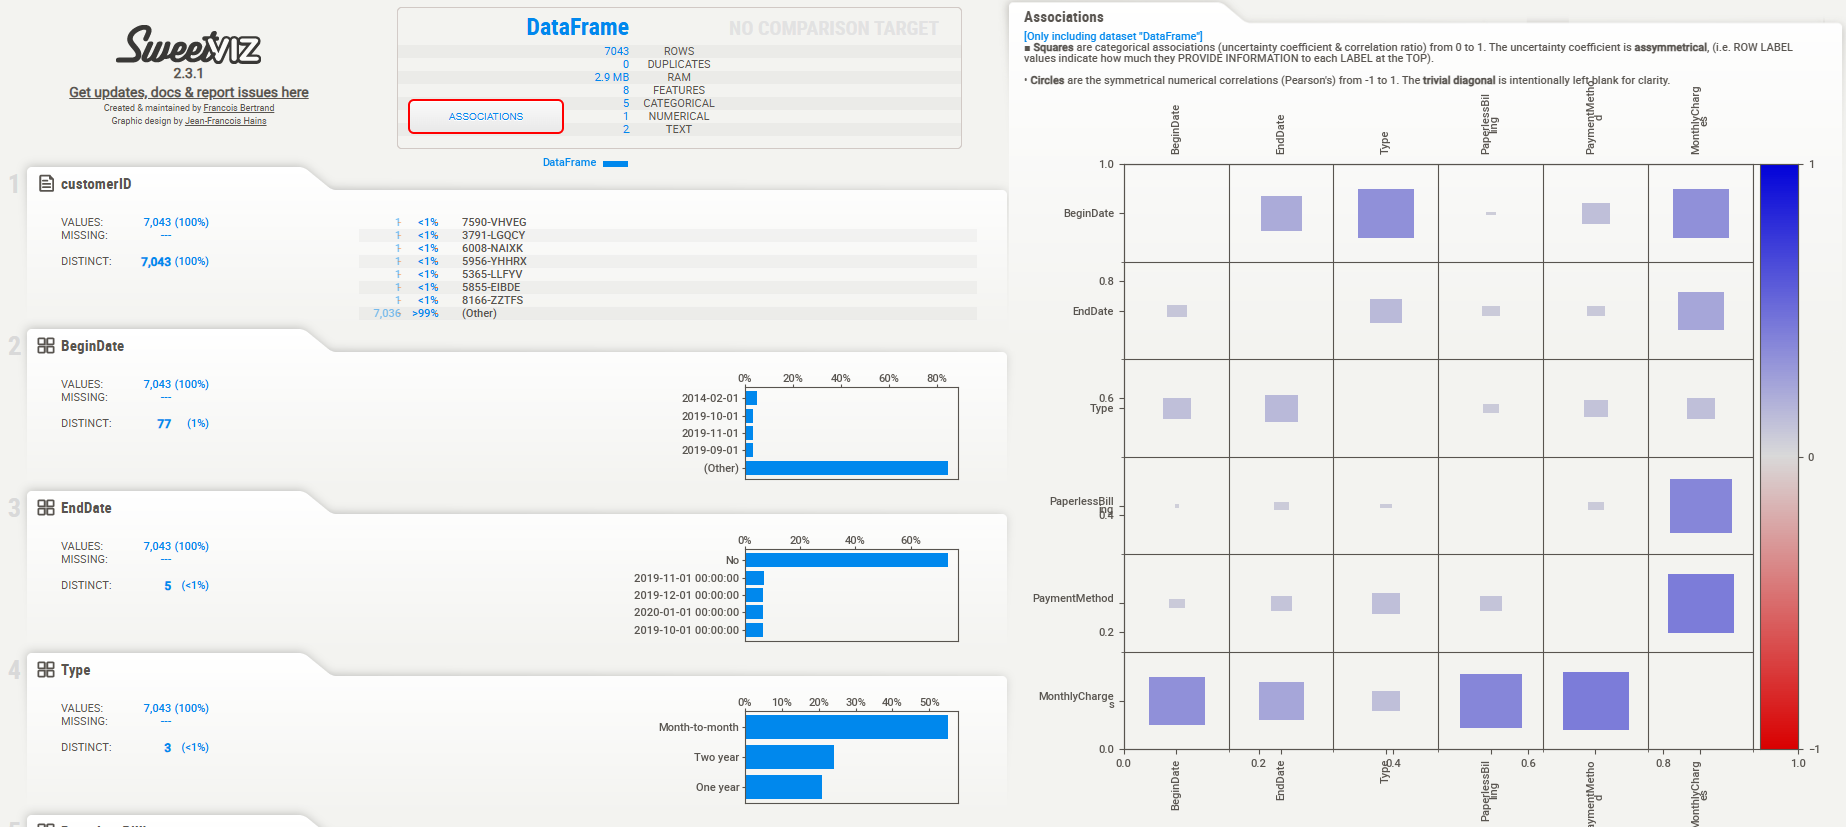
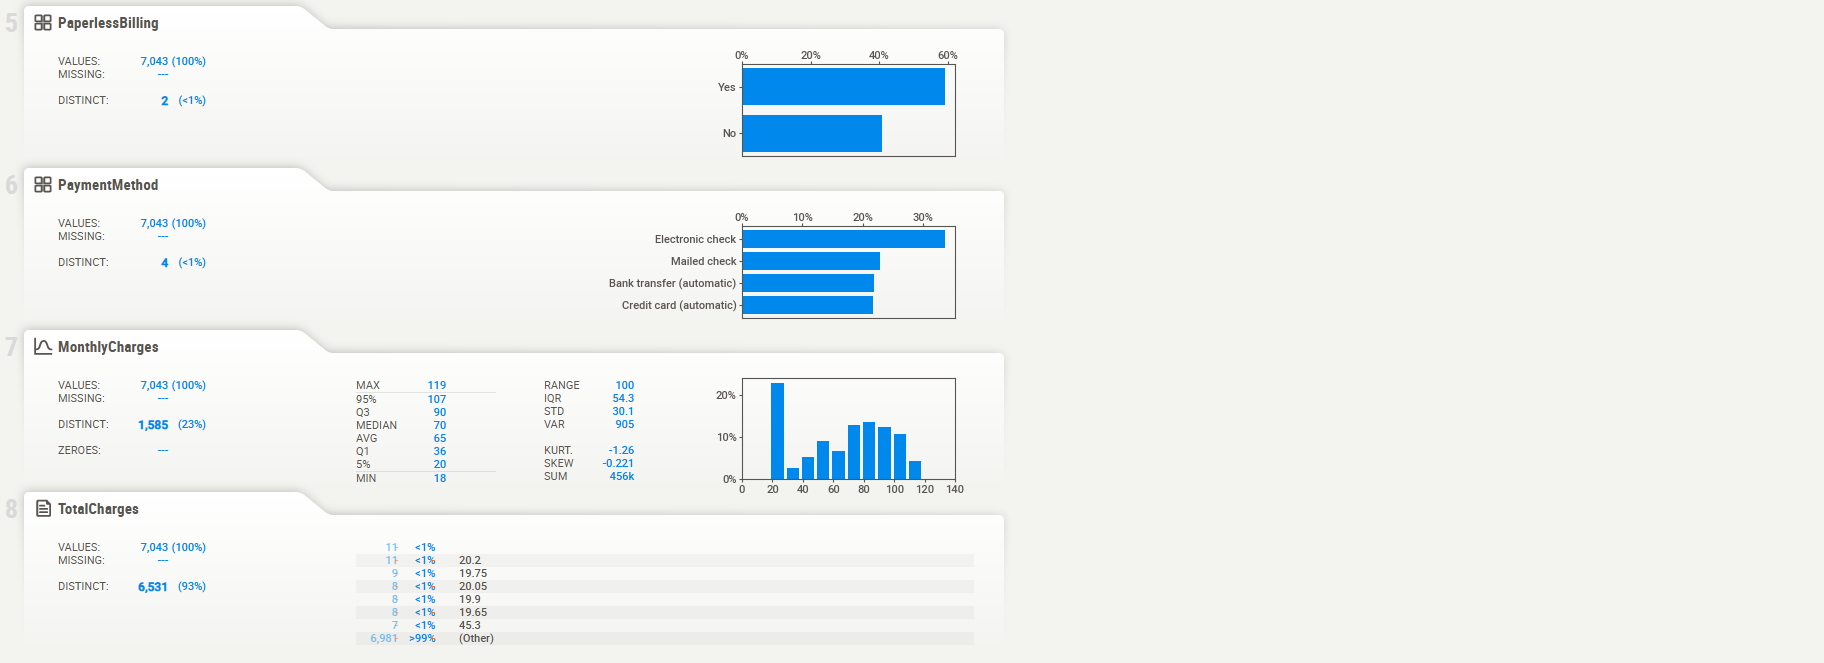

*Conclusiones:* contenido 7,034 líneas y 8 columnas (características) que se dividen en 5 categóricas, 1 numérica y 2 de texto, no cuenta con valores duplicados.

- customerID: son 7,043 valores únicos alfanuméricos.
- BeginDate: se tienen 77 fechas distintas que representan el 1% de las 7,043 lineas, el resto no se tiene fechas.
- EndDate: solamente se cuenta con 5 fechas diferentes que representan menos del 1% del total, el resto NO tiene fechas debido a que siguen siendo clientes activos. 
- Type: se tienen 3 tipos diferentes de contratos, el más común es el mensual, seguido del plan a 2 años y por último el plan anual.
- PaperlessBilling: la mayor cantidad de clientes prefieren la facturación digital cerca del 60% y el resto 40% papel impreso.
- PaymentMethod: se tienen 4 métodos de pago siendo el más importante el cheque electrónico, seguido de cheque por correo, después transferencia bancaria y por último tarjeta de crédito.
- MonthlyCharges: los montos van desde $18 ahasta $119 con un promedio de $65 y mediana de $70.
- TotalCharges: se tienen 6,531 valores únicos que representan 93% del total de las 7,043 lineas, el resto parecen ser valores no numéricos que deberan revisarse a detalle.

Reporte del dataframe `Personal`

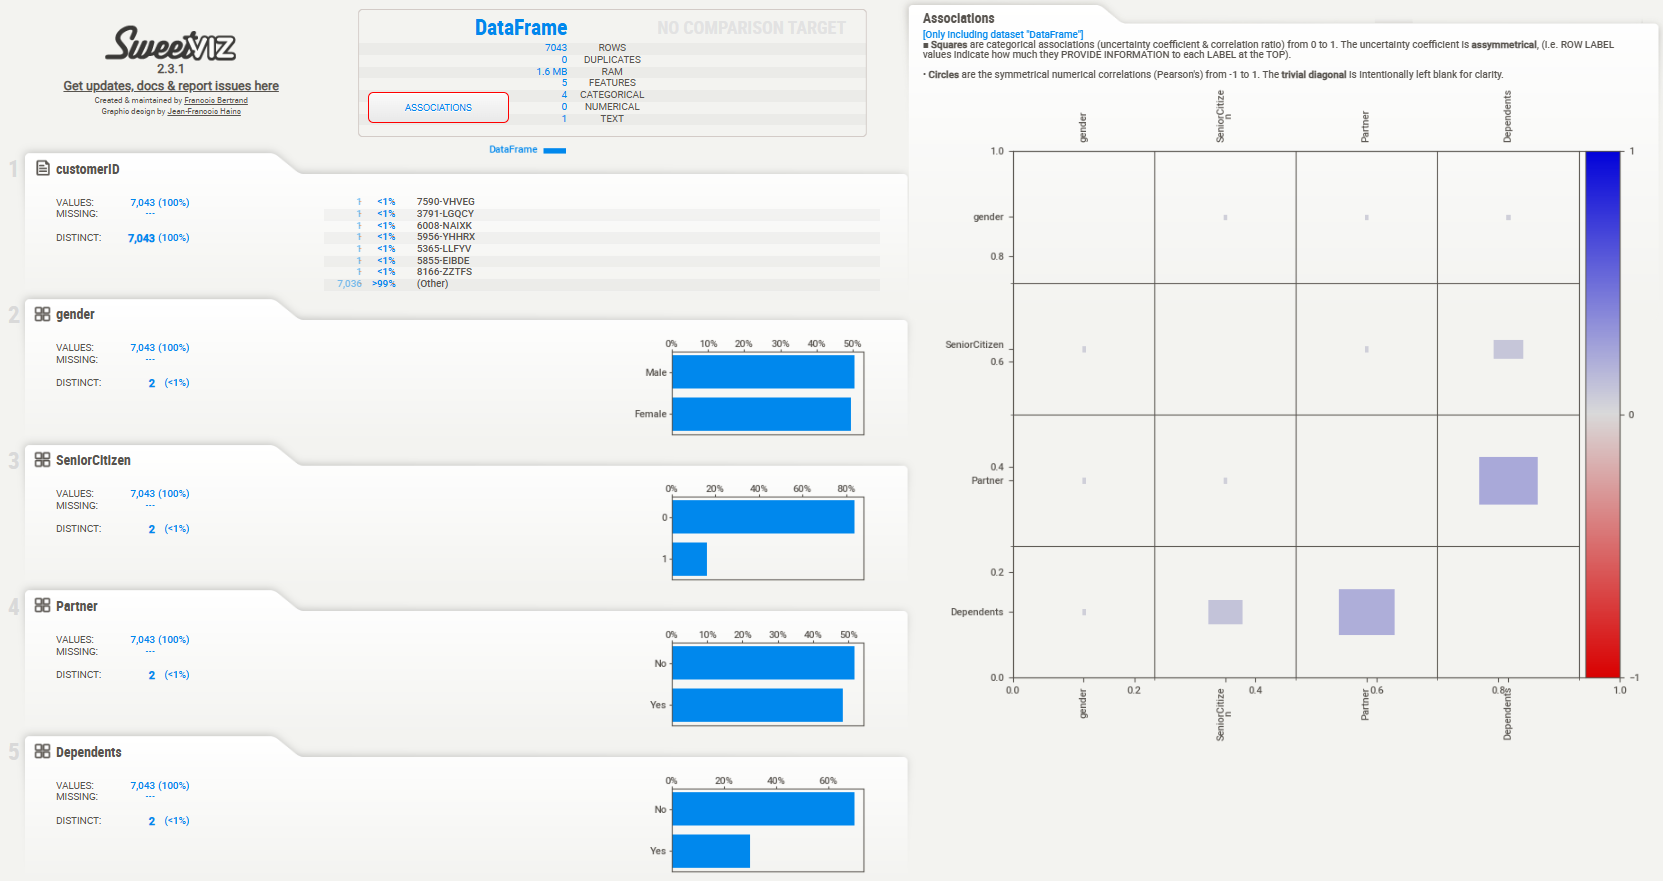

*Conclusiones:* contenido 7,034 líneas y 5 columnas (características) que se dividen en 4 categóricas y 1 de texto, no cuenta con valores duplicados.

- customerID: son 7,043 valores únicos alfanuméricos.
- gender: dos valores únicos (Male 3,555 ~ 50% & Female 3,488 ~ 50%).
- SeniorCitizen: un total de 1,142 personas jubiladas 16%, contra el resto 5,901 representan el 84% del total.
- Partner: una pequeña mayor parte son personas sin pareja el 52% con 3,641 lineas, el resto tiene pareja 48% con 3,402 líneas.
- Dependents: la mayor parte de las personas NO tienen dependientes económicos el 70% con 4,933 líneas, mientras que el resto 30% con 2,110 líneas si tienen.

Reporte del dataframe de `Internet`

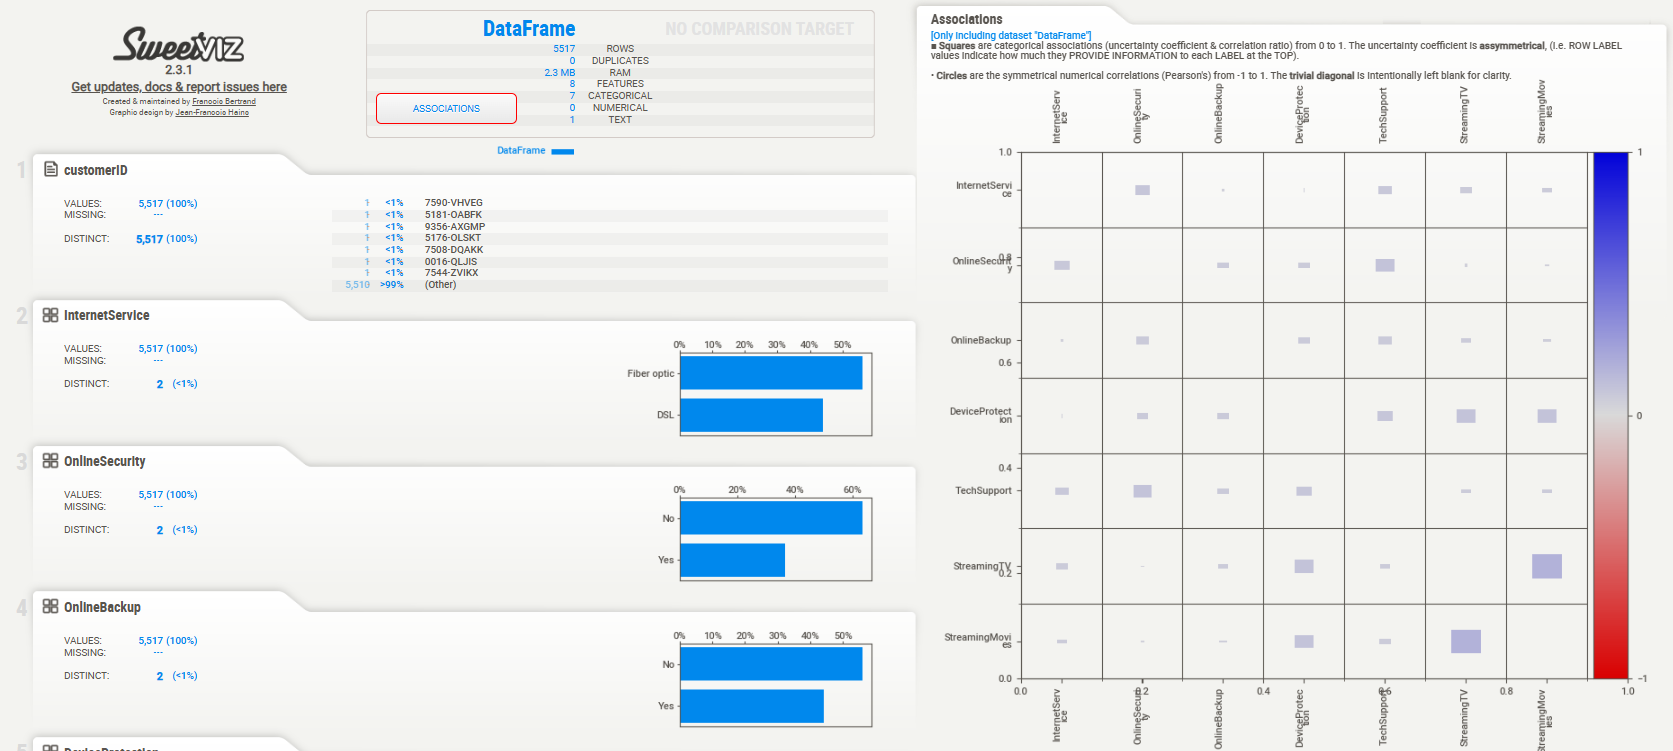
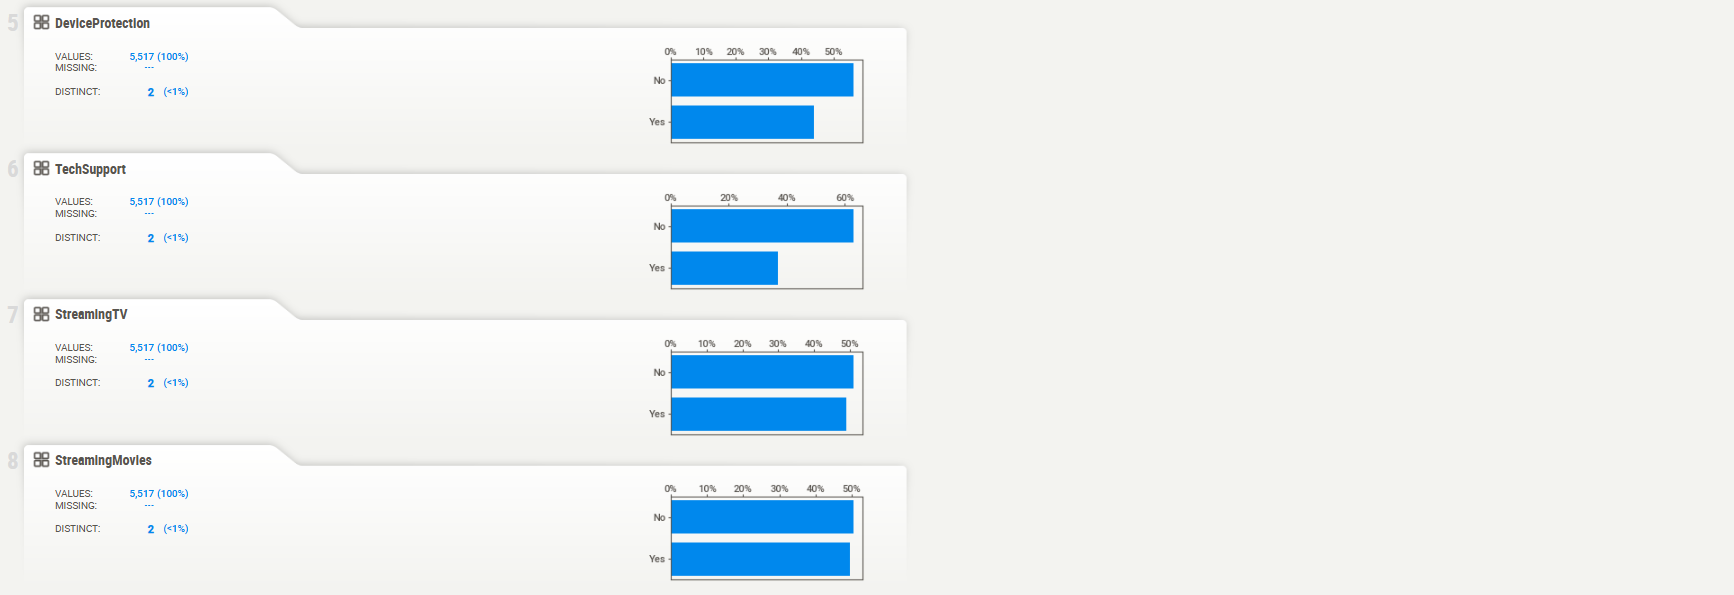

*Conclusiones:* contenido 5,517 líneas y 8 columnas (características) que se dividen en 7 categóricas y 1 de texto, no cuenta con valores duplicados.

- customerID: son 5,517 valores únicos alfanuméricos.
- InternetService: dos categorías, Fibra Óptica 56% con 3,096 líneas & DSL 44% con 2,421 líneas.
- OnlineSecurity: la mayoría NO cuenta con el servicio 3,498 ~ 63% vs SI con 2,019 ~ 37% de personas.
- OnlineBackup: la mayoría NO cuenta con el servicio 3,068 ~ 56% vs SI con 2,429 ~ 44% de personas.
- DeviceProtection: la mayoría NO cuenta con el servicio 3,095 ~ 56% vs SI  con 2,422 ~ 44% de personas.
- TechSupport: la mayoría NO cuenta con el servicio 3,473 ~ 63% vs SI con 2,044 ~ 37% de personas.
- StreamingTV: muy similar las cantidades, NO tienen el servicio el 51% ~ 2,810 vs el 49% ~ 2,707 personas.
- StreamingMovies: muy similar las cantidades, NO tienen el servicio el 50% ~ 2,785 vs el 50% ~ 2,732 personas.

NOTA: se nota una fuerte correlación entre las variables 'StreamingTV' & 'StreamingMovies'; así como también, en las variables 'StreamingTV' & 'DeviceProtection', en 'StreamingMovies' & 'DeviceProtection' y finalmente en 'TechSupport' & 'OnlineSecurity'.

Reporte del dataframe `Telefonía`

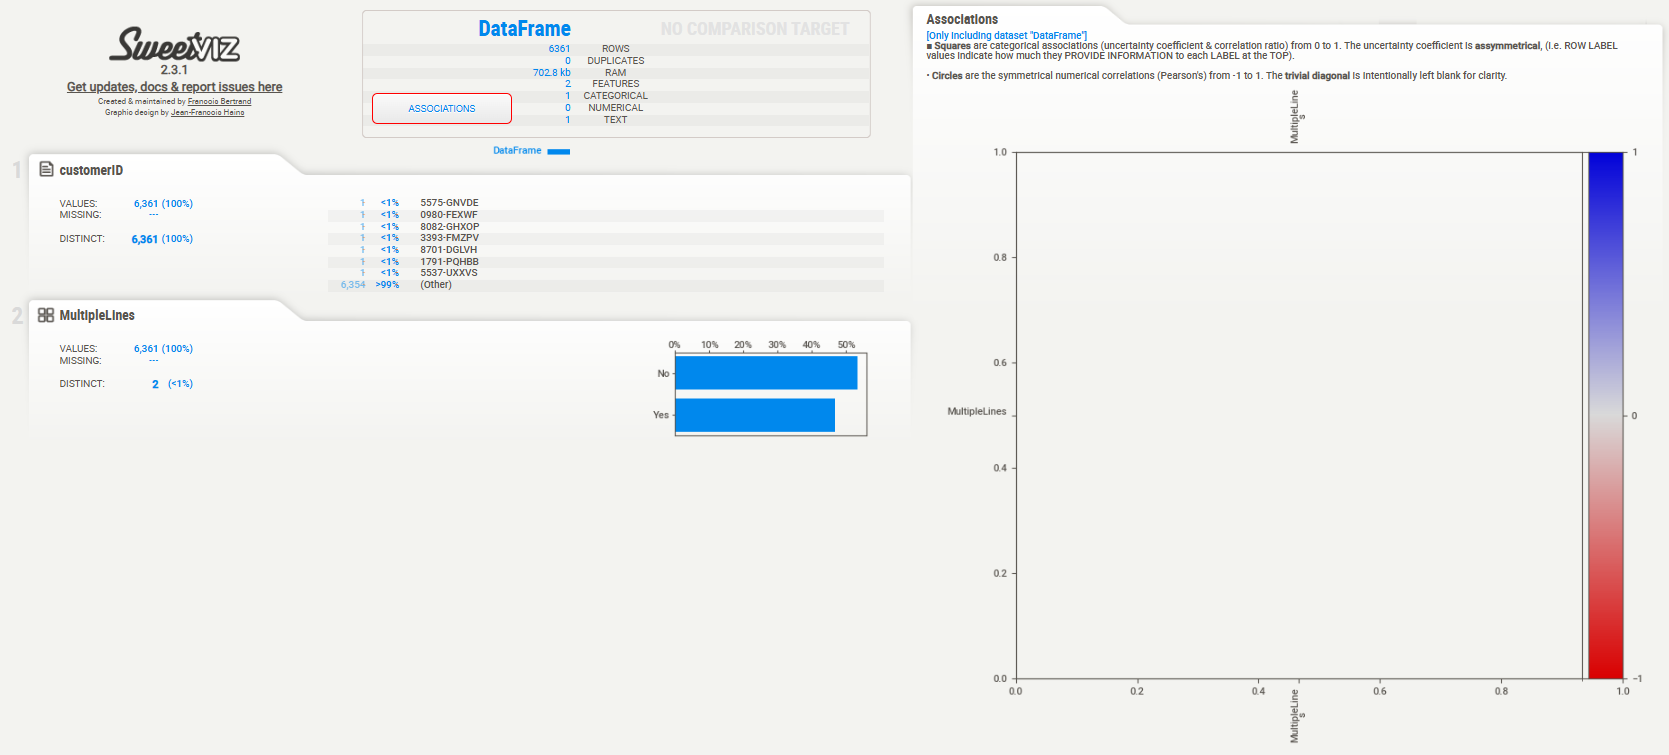

*Conclusiones:* contenido 6,361 líneas y 2 columnas (características) que se dividen en 1 categórica y 1 de texto, no cuenta con valores duplicados.

- customerID: son 6,361 valores únicos alfanuméricos.
- MultipleLines: dos valores unicos, NO cuentan con varias líneas la ayoría el 53% con 3,390 vs SI el 47% con 2,971 personas.

Ahora realizaremos la exploración tradicional con métodos de la librería pandas, para detectar los más detalles o las posibles anomalías.

### Contratos (exploración)

In [4]:
raw_contract.info()
print()
raw_contract.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


In [5]:
display(raw_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [6]:
display(raw_contract.shape)
raw_contract.columns.tolist()

(7043, 8)

['customerID',
 'BeginDate',
 'EndDate',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges']

#### Diccionario para Contratos

El daataser contiene 7,043 líneas y 8 columnas, no hay datos nulos, los tipos de datos se deben corregir en el caso de las fechas de inicio y fin de contrato, y también los datos de costos ($) deben ser de tipo 'float'.
Se tienen columnas con datos categóricos, numéricos y de fechas, dichas columnas contienen la siguiente información:

   `'customerID'` - Clave alfanumérica única de identificación por cliente
   
   `'BeginDate'` - Fecha de inicio de contrato o servicio
   
   `'EndDate'` - Fecha de fin de contrato o servicio
   
   `'Type'` - Tipo de contrato (mensual, anual o dos años)
   
   `'PaperlessBilling'` - Recibo o factura dígial
   
   `'PaymentMethod'` - Método de pago (cheque electrónico, cheque en correo, transferencia bancaria y tarjeta de crédito)
   
   `'MonthlyCharges'` - Cargos mensuales
   
   `'TotalCharges'` - Cargos totales

In [7]:
# Enlistamos los valores únicos por columnas seleccionada

columns_to_check = ['Type', 'PaperlessBilling', 'PaymentMethod']

for column in columns_to_check:
    unique_values = raw_contract[column].unique()
    print(f'Valores únicos en la columna "{column}": {unique_values}\n')

Valores únicos en la columna "Type": ['Month-to-month' 'One year' 'Two year']

Valores únicos en la columna "PaperlessBilling": ['Yes' 'No']

Valores únicos en la columna "PaymentMethod": ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']



### Info Personal (exploración)

In [8]:
raw_personal.info()
print()
raw_personal.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB



,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


In [9]:
display(raw_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [10]:
display(raw_personal.shape)
raw_personal.columns.tolist()

(7043, 5)

['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']

#### Diccionario para Personal

El dataset de personal contiene 7,043 líneas y 5 columnas, no se tienen datos nulos y los tipos de datos son correctos, las columnas contienen la siguiente información.

`'customerID'` - Clave alfanumérica única de identificación por cliente

`'gender'` - Género (masculino/femenino)

`'SeniorCitizen'` - Ciudadano jubilado (0-1)

`'Partner'` - Periente (Si/No)

`'Dependents'` - Dependientes económicos (Si/No)

In [11]:
# Enlistamos los valores únicos por columnas seleccionada

columns_to_check = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

for column in columns_to_check:
    unique_values = raw_personal[column].unique()
    print(f'Valores únicos en la columna "{column}": {unique_values}\n')

Valores únicos en la columna "gender": ['Female' 'Male']

Valores únicos en la columna "SeniorCitizen": [0 1]

Valores únicos en la columna "Partner": ['Yes' 'No']

Valores únicos en la columna "Dependents": ['No' 'Yes']



### Internet (exploración)

In [12]:
raw_internet.info()
print()
raw_internet.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [13]:
display(raw_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [14]:
display(raw_internet.shape)
raw_internet.columns.tolist()

(5517, 8)

['customerID',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

#### Diccionario para Internet

Este dataset contiene un total de 5,517 líneas y 8 columnas, no hay datos nulos y los tipos de datos se pueden dejar como están, las columnas contienen la siguiente información:

 `'customerID'` - Clave alfanumérica única de identificación por cliente
 
 `'InternetService'` - Servicio de internet por DSL o Fibra óptica
 
 `'OnlineSecurity'` - Seguridad en línea (Si/No)
 
 `'OnlineBackup'` - Respaldo en línea (Si/No)
 
 `'DeviceProtection'` - Protección de dispositivos (Si/No)
 
 `'TechSupport'` - Soporte técnico (Si/No)
 
 `'StreamingTV'` - Televisión por streaming (Si/No)
 
 `'StreamingMovies'` - Películas por streaming (Si/No)

In [15]:
# Enlistamos los valores únicos por columnas seleccionada

columns_to_check = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for column in columns_to_check:
    unique_values = raw_internet[column].unique()
    print(f'Valores únicos en la columna "{column}": {unique_values}\n')

Valores únicos en la columna "InternetService": ['DSL' 'Fiber optic']

Valores únicos en la columna "OnlineSecurity": ['No' 'Yes']

Valores únicos en la columna "OnlineBackup": ['Yes' 'No']

Valores únicos en la columna "DeviceProtection": ['No' 'Yes']

Valores únicos en la columna "TechSupport": ['No' 'Yes']

Valores únicos en la columna "StreamingTV": ['No' 'Yes']

Valores únicos en la columna "StreamingMovies": ['No' 'Yes']



### Telefonía (exploración)

In [16]:
raw_phone.info()
print()
raw_phone.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB



,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


In [17]:
display(raw_phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [18]:
display(raw_phone.shape)
raw_phone.columns.tolist()

(6361, 2)

['customerID', 'MultipleLines']

#### Diccionario para Telefonía

El último dataset llamado teléfono, contiene un total de 6,361 líneas y 2 columnas únicamente, no hay datos nulos y los tipos de datos son correctos; las columnas contienen la siguiente información:

`'customerID'` - Clave alfanumérica única de identificación por cliente

`'MultipleLines'` - Múltiples líneas (Si/No)

In [19]:
# Enlistamos los valores únicos por la columna seleccionada

columns_to_check = ['MultipleLines']

for column in columns_to_check:
    unique_values = raw_phone[column].unique()
    print(f'Valores únicos en la columna "{column}": {unique_values}\n')

Valores únicos en la columna "MultipleLines": ['No' 'Yes']



## 2. Preprocesamiento de los datos

Antes de comenzar el preprocesamiento de los datos, vamos a crear nuevas variables realizando una copia de los dataframes originales.

In [20]:
contract = raw_contract.copy()
personal = raw_personal.copy()
internet = raw_internet.copy()
phone = raw_phone.copy()

En el preprocesamiento vamos a realizar los siguientes cambios para cada uno de los dataframes.

1. Ingeniería de Características (creación de nuevas columnas)
2. Corrección de los tipos de datos (dtypes)
3. Homologación de los nombres de columnas (snake_case)
4. Búsqueda de datos nulos y/o duplicados (NaN / Dupls)
5. Revision del balance de clases (porcentajes)

Definimos algunas funciones que nos ayudarán con el preprocesamiento:

In [21]:
def to_snake_case(text):
    """
    Convierte un texto a formato snake_case.
    """
    # Reemplaza espacios y guiones por guiones bajos
    text = re.sub(r'[\s\-]+', '_', text)
    # Separa camelCase o PascalCase
    text = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', text)
    # Evita dobles guiones bajos
    text = re.sub(r'__+', '_', text)
    # Elimina guiones bajos iniciales/finales y convierte a minúsculas
    return text.strip('_').lower()

In [22]:
def encode_yes_no(df_all, columns):
    """
    Convierte columnas categóricas binarias 'Yes'/'No' a 1/0.
    """
    for col in columns:
        df_all[col] = df_all[col].map({'Yes': 1, 'No': 0})

In [23]:
def value_percentages(df_all, excluir=None):
    """
    Calcula el porcentaje de cada valor único por columna.
    
    Argumentos:
        df_all (DataFrame): El DataFrame de entrada.
        excluir (lista): Lista de nombres de columnas a excluir (opcional).
        
    Retorna:
        dict: Diccionario con Series de porcentajes por columna.
    """
    if excluir is None:
        excluir = []

    resultado = {}
    for col in df_all.columns:
        if col not in excluir:
            porcentaje = (df_all[col].value_counts(normalize=True, dropna=False) * 100).round(2)
            resultado[col] = porcentaje

    for col, dist in resultado.items():
        print(f"\n📊 {col}")
        print(dist)

    return 

### Contratos (feat_eng, dtypes, cols, nan, dupls)

In [24]:
display(contract.head())
contract.dtypes

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object

Vamos a comenzar con las correcciones de tipos de datos.

In [25]:
# Convertir columnas a tipo datetime
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], errors='coerce')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')

# Cambiamos el tipo de dato en las columnas numericas que están como object
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

# Verificamos los tipos de datos correjidos
contract.dtypes

customerID                  object
BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
dtype: object

Vamos a crear nuevas columnas (características) con la información de las fechas de Inicio y Fin de los contratos, esto servirá a los modelos de predicción de tipo "churn"

1. `ContractDuration` (duración del contrato)
2. `Tenure` (antigüedad del cliente)
3. `Churn` (rotación).

Creamos la columna `Duración del contrato`, esta columna representa el tiempo total que dura el contrato, desde el inicio hasta el final.

1. Vamos a restar la Fecha final menos la Fecha inicial, obteniedo los días.
2. Cuando no tenemos la Fecha final; es decir, tenemos un "No" vamos a considerar la columna llamada 'Type' o tipo de contrato que nos indica si es mensual, anual o dos años.
3. Rellenamos los datos nulos en la nueva columna de Duración de contrato con la información anterior.
4. Creamos otra columna que covierta los días en meses dividiendo entre 30 días todas las cifras calculadas.

In [26]:
# Calcular duración del contrato en días Fecha final menos Fecha inicial
contract['ContractDurationDays'] = (contract['EndDate'] - contract['BeginDate']).dt.days

# Mapear valores cuando EndDate no es una fecha válida (No)
duration_map = {
    'Month-to-month': 30,
    'One year': 365,
    'Two year': 730
}

# Rellenar valores nulos con base en la columna 'Type'
contract['ContractDurationDays'] = contract['ContractDurationDays'].fillna(contract['Type'].map(duration_map))

# Crear una nueva columna con la duración del contrato en meses
contract['ContractDurationMonths'] = contract['ContractDurationDays'] // 30

# Imprimimos los primeros registros para verificar
display(contract.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDurationDays,ContractDurationMonths
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,30.0,1.0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,365.0,12.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61.0,2.0
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,365.0,12.0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61.0,2.0


Ahora creamos la columna `Tenure` (antigüedad del cliente), esta columna indica cuánto tiempo ha estado activo el cliente hasta una fecha de referencia del análisis, en este caso es la última fecha de EndDate más 30 días "2020-02-01".

1. Restamos la fecha de referencia menos la fecha inicial del contrato, cálculo en días.
2. La cantidad calculada la dividimos entre 30 días para calcular los meses.

In [27]:
# Verificamos las fechas iniciales y finales
contract['BeginDate'].min(), contract['EndDate'].max()

(Timestamp('2013-10-01 00:00:00'), Timestamp('2020-01-01 00:00:00'))

In [28]:
# Fecha de referencia para calcular la antigüedad
reference_date = pd.to_datetime('2020-02-01')

# Creamos la nueva columa 'TenureDays' y 'TenureMonths'
contract['TenureDays'] = (reference_date - contract['BeginDate']).dt.days
contract['TenureMonths'] = contract['TenureDays'] // 30

# Imprimimos los primeros registros para verificar
display(contract.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDurationDays,ContractDurationMonths,TenureDays,TenureMonths
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,30.0,1.0,31,1
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,365.0,12.0,1036,34
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61.0,2.0,123,4
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,365.0,12.0,1371,45
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61.0,2.0,153,5


Notamos que la columna llamada 'EndDate' podemos utilizarla para crear una nueva columna "objetivo", cambiando las fechas a un 'Yes', revisemos cuáles son dichas fechas.

In [29]:
# Verificamos los valores únicos
contract['EndDate'].value_counts()

EndDate
2019-11-01    485
2019-12-01    466
2020-01-01    460
2019-10-01    458
Name: count, dtype: int64

Utilizando la técnica *Feature Engineering* creamos una nueva columna a partir de la llamada 'EndDate' para definir la rotación o mejor conocida como ´churn´, con esto podemos clasificar a los clientes que han dejado la compañía con 1 y los que siguen siendo clientes vigentes con 0.

In [30]:
# Creamos la nueva columa 'churn' que indique si el cliente ha cancelado el servicio 'Yes'
contract['churn'] = contract['EndDate'].replace(['2019-11-01', '2019-12-01', '2020-01-01', '2019-10-01'], 'Yes')

# Rellenamos los valores nulos con 'No'
contract['churn'] = contract['churn'].fillna('No')

# Verificamos los valores únicos
contract['churn'].value_counts()

churn
No     5174
Yes    1869
Name: count, dtype: int64

Los valores anteriores nos indican que tenemos 5,174 clientes activos y 1,869 clientes que han cancelado su contrato en las fechas anteriores.

Continuemos con las demás actividades del preprocesamiento.

In [31]:
# Aplicamos la función a los nombres de las columnas
contract.columns = [to_snake_case(col) for col in contract.columns]

# Verificamos los nombres de las columnas
contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges',
       'contract_duration_days', 'contract_duration_months', 'tenure_days',
       'tenure_months', 'churn'],
      dtype='object')

Ahora estamos seguros de que los cambios son correctos, tanto en los tipos de datos, la generación de nuevas columnas y en los nombres de las columnas normalizadas.

Después vamos a codificar los valores categóricos de No y Yes en 0 y 1 respectivamente de la columna llamada 'paperless_billing' y 'churn'.

In [32]:
# Aplicamos la función para codificar variables categóricas binarias Yes/No
encode_yes_no(contract, ['paperless_billing', 'churn'])

# Verificamos los cambios
display(contract.head())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_duration_days,contract_duration_months,tenure_days,tenure_months,churn
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,30.0,1.0,31,1,0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,365.0,12.0,1036,34,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,61.0,2.0,123,4,1
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,365.0,12.0,1371,45,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,61.0,2.0,153,5,1


Ahora revisamos el dataframe en busca de valores nulos y duplicados.

In [33]:
# Revisión de valores duplicados
print('El total de datos duplicados es:', contract.duplicated().sum())

El total de datos duplicados es: 0


In [34]:
# Búsqueda de valores nulos
print('El total de datos nulos por columna es:\n', contract.isna().sum())

El total de datos nulos por columna es:
 customer_id                    0
begin_date                     0
end_date                    5174
type                           0
paperless_billing              0
payment_method                 0
monthly_charges                0
total_charges                 11
contract_duration_days         0
contract_duration_months       0
tenure_days                    0
tenure_months                  0
churn                          0
dtype: int64


In [35]:
# Imputamos los valores nulos en 'end_date' con 'No'
contract['end_date'] = contract['end_date'].fillna('No')

In [36]:
# Mostramos las filas con NaN en la columna 'total_charges'
contract[contract['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_duration_days,contract_duration_months,tenure_days,tenure_months,churn
488,4472-LVYGI,2020-02-01,No,Two year,1,Bank transfer (automatic),52.55,NaN,730.0,24.0,0,0,0
753,3115-CZMZD,2020-02-01,No,Two year,0,Mailed check,20.25,NaN,730.0,24.0,0,0,0
936,5709-LVOEQ,2020-02-01,No,Two year,0,Mailed check,80.85,NaN,730.0,24.0,0,0,0
1082,4367-NUYAO,2020-02-01,No,Two year,0,Mailed check,25.75,NaN,730.0,24.0,0,0,0
1340,1371-DWPAZ,2020-02-01,No,Two year,0,Credit card (automatic),56.05,NaN,730.0,24.0,0,0,0
3331,7644-OMVMY,2020-02-01,No,Two year,0,Mailed check,19.85,NaN,730.0,24.0,0,0,0
3826,3213-VVOLG,2020-02-01,No,Two year,0,Mailed check,25.35,NaN,730.0,24.0,0,0,0
4380,2520-SGTTA,2020-02-01,No,Two year,0,Mailed check,20.00,NaN,730.0,24.0,0,0,0
5218,2923-ARZLG,2020-02-01,No,One year,1,Mailed check,19.70,NaN,365.0,12.0,0,0,0
6670,4075-WKNIU,2020-02-01,No,Two year,0,Mailed check,73.35,NaN,730.0,24.0,0,0,0


In [37]:
# Verificamos las fechas iniciales y finales
contract['begin_date'].min(), contract['begin_date'].max()

(Timestamp('2013-10-01 00:00:00'), Timestamp('2020-02-01 00:00:00'))

La última fecha en el dataframe es el '2020-02-01' y es el dato en común de los clientes que no tienen cargos totales.

Por lo que los valores nulos encontrados en la columna 'total_charges' es debido a que los clientes son nuevos, por lo que podemos suponer que el monto de cargos totales, es igual al cargo de la columna 'monthly_charges'.

In [38]:
# Imputamos los valores nulos en 'total_charges' con los valores de 'monthly_charges'
contract['total_charges'].fillna(contract['monthly_charges'], inplace=True)

# Verificamos que no haya más valores nulos
contract.isna().sum()

customer_id                 0
begin_date                  0
end_date                    0
type                        0
paperless_billing           0
payment_method              0
monthly_charges             0
total_charges               0
contract_duration_days      0
contract_duration_months    0
tenure_days                 0
tenure_months               0
churn                       0
dtype: int64

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Correcto, asegurar la calidad de los datos es un paso vital cuando se trata de entrenar modelos de ML, ya que datos de baja calidad representan predicciones de baja calidad también
</div>

Finalmente revisamos el balance de las clases para las columnas categpricas.

In [39]:
# Revisamos el porcentaje de los datos en cada columna
value_percentages(contract, excluir=['customer_id', 'begin_date', 'end_date', 'monthly_charges', 'total_charges'])


📊 type
type
Month-to-month    55.02
Two year          24.07
One year          20.91
Name: proportion, dtype: float64

📊 paperless_billing
paperless_billing
1    59.22
0    40.78
Name: proportion, dtype: float64

📊 payment_method
payment_method
Electronic check             33.58
Mailed check                 22.89
Bank transfer (automatic)    21.92
Credit card (automatic)      21.61
Name: proportion, dtype: float64

📊 contract_duration_days
contract_duration_days
30.0      34.10
730.0     23.71
365.0     19.10
31.0       2.81
61.0       1.75
          ...  
1552.0     0.03
1340.0     0.01
1218.0     0.01
1917.0     0.01
2161.0     0.01
Name: proportion, Length: 131, dtype: float64

📊 contract_duration_months
contract_duration_months
1.0     36.92
24.0    23.71
12.0    19.10
2.0      1.75
3.0      1.33
        ...  
60.0     0.09
73.0     0.09
62.0     0.07
64.0     0.06
63.0     0.06
Name: proportion, Length: 73, dtype: float64

📊 tenure_days
tenure_days
2191    5.20
123     3.37
92    

*Conclusiones:* 

- Para los tipos de contrato, podemos notar que la mitad de los clientes el 55% tienen contratos mensuales, mientras  que una cuarta 24% parte tienen contratos de 2 años y el resto 21% contratos de 1 año.

- En la facturación podemos notar que la gran moyoría prefiere la factura digital 59% contra el resto 40% solicita la factura impresa.

- Para el método de pago, las personas prefieren el Cheque electrónico con un 33%, seguido de Cheque por correo con un 23%, luego la Transferencia bancaria con 22% y el menos utiliado es la Tarjeta de Crédito con 21%.

- Las nuevas columnas sobre la Duración de contrato, notamos que la gran mayoría el 34% de personas tienen un contrato de 30 días equivalente a 1 mes, seguido del 23% tienen contratos de 730 días o 24 meses ~ 2 años, después le sigue el 19% tienen contratos de 365 días o 12 meses ~ 1 año.

- Las otras nuevas columnas llamadas Tanure Days y Months, muestran que la mayoría de los clientes 5% llevan 2,191 días con el servicio, que es lo mismo que 73 meses o 3 años, el resto de clientes llevan mucho menos tiempo con los servicios.

- La nueva columna objetivo 'churn' tenemos que el 73% siguen siendo clientes habituales y sólo el 26% han dejado de ser clientes.

### Info Personal (feat_eng, dtypes, cols, nan, dupls)

In [40]:
display(personal.head())
personal.dtypes

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


customerID       object
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
dtype: object

In [41]:
personal['gender'].value_counts()

gender
Male      3555
Female    3488
Name: count, dtype: int64

Aplicamos Ingeniería de Datos para transformar las columnas categórias en numéricas.

In [42]:
# Reemplazamos los valores 'Female' y 'Male' por 0 y 1 respectivamente
personal['gender'] = personal['gender'].map({'Female': 0, 'Male': 1})

# Aplicamos la función para codificar variables categóricas binarias Yes/No
encode_yes_no(personal, ['Partner', 'Dependents'])

# Verificamos los cambios
display(personal.head())

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,0,0,1,0
1,5575-GNVDE,1,0,0,0
2,3668-QPYBK,1,0,0,0
3,7795-CFOCW,1,0,0,0
4,9237-HQITU,0,0,0,0


Normalizamos los nombres de las columnas.

In [43]:
# Aplicamos la función a los nombres de las columnas
personal.columns = [to_snake_case(col) for col in personal.columns]

# Verificamos los nombres de las columnas
personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

Revisamos por valores duplicados y nulos.

In [44]:
# Revisión de valores duplicados
print('El total de datos duplicados es:', personal.duplicated().sum())

El total de datos duplicados es: 0


In [45]:
# Búsqueda de valores nulos
print('El total de datos nulos por columna es:\n', personal.isna().sum())

El total de datos nulos por columna es:
 customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64


In [46]:
# Revisamos los tipos de datos
personal.dtypes

customer_id       object
gender             int64
senior_citizen     int64
partner            int64
dependents         int64
dtype: object

Finalmente revisamos el balance de las clases.

In [47]:
# Revisamos el porcentaje de los datos en cada columna
value_percentages(personal, excluir=['customer_id'])


📊 gender
gender
1    50.48
0    49.52
Name: proportion, dtype: float64

📊 senior_citizen
senior_citizen
0    83.79
1    16.21
Name: proportion, dtype: float64

📊 partner
partner
0    51.7
1    48.3
Name: proportion, dtype: float64

📊 dependents
dependents
0    70.04
1    29.96
Name: proportion, dtype: float64


*Conclusiones*:

- La clase de género está casi balanceada, los hombres con el 50.48% y las mujeres con 49.52%

- Las personas jubiladas (1) representan la menor cantidad 16% del total de los clientes.

- Los clientes sin pareja resultan ser un pocomás 51.7% que las ppersonas solteras 48.3%.

- Las personas con dependientes ascienden casi al 30% contra el 70% que no tienen dependientes económicos.

### Internet (feat_eng, dtypes, cols, nan, dupls)

In [48]:
display(internet.head())
internet.dtypes

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


customerID          object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
dtype: object

Aplicamos Ingeniería de Datos para transformar las columnas categórias en numéricas.

In [49]:
# Revisamos las cantidades de los tipos de servicio de internet
internet['InternetService'].value_counts()

InternetService
Fiber optic    3096
DSL            2421
Name: count, dtype: int64

In [50]:
# Convertimos los tipos de internet a binarios, donde 'DSL' es 0 y 'Fiber optic' es 1
# internet['InternetService'] = internet['InternetService'].map({'DSL': 0, 'Fiber optic': 1})

# Aplicamos la función para codificar variables categóricas binarias Yes/No
encode_yes_no(internet, ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'])

# Aplicamos la función a los nombres de las columnas
internet.columns = [to_snake_case(col) for col in internet.columns]

# Verificamos los cambios
display(internet.head())

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0
3,7795-CFOCW,DSL,1,0,1,1,0,0
4,9237-HQITU,Fiber optic,0,0,0,0,0,0


Revisamos por valores duplicados y nulos.

In [51]:
# Revisamos valores duplicados
print('El total de datos duplicados es:', internet.duplicated().sum())
print()
# Búsqueda de valores nulos
print('El total de datos nulos por columna es:\n', internet.isna().sum())

El total de datos duplicados es: 0

El total de datos nulos por columna es:
 customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64


In [52]:
# Revisamos el porcentaje de los datos en cada columna
value_percentages(internet, excluir=['customer_id'])


📊 internet_service
internet_service
Fiber optic    56.12
DSL            43.88
Name: proportion, dtype: float64

📊 online_security
online_security
0    63.4
1    36.6
Name: proportion, dtype: float64

📊 online_backup
online_backup
0    55.97
1    44.03
Name: proportion, dtype: float64

📊 device_protection
device_protection
0    56.1
1    43.9
Name: proportion, dtype: float64

📊 tech_support
tech_support
0    62.95
1    37.05
Name: proportion, dtype: float64

📊 streaming_tv
streaming_tv
0    50.93
1    49.07
Name: proportion, dtype: float64

📊 streaming_movies
streaming_movies
0    50.48
1    49.52
Name: proportion, dtype: float64


*Conclusiones*:

- El servicio de internet preferido es el de Fibra Óptica con un 56%, el resto 43.8% utiliza DSL.

- La seguridad en línea está contratada por un 36% unicamente, donde claramente hay una oportunidad de crecer el negocio.

- El respaldo en línea lo tiene la minoría que es 44% contratado el servicio contra el resto 56% que no lo tiene. 

- La protección de dispositivos igual lo tiene la minoría un 44% de clientes contra el resto 56% que no lo tiene. 

- La demanda de TV en línea está bien balanceado con 51% lo tiene contra el 49% que no lo tiene. 

- La demanda de películas en línea igual balanceado 51% lo tiene contra el 49% no lo tiene.

### Telefonía (feat_eng, dtypes, cols, nan, dupls)

In [53]:
display(phone.head())
phone.dtypes

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


customerID       object
MultipleLines    object
dtype: object

Aplicamos codificación para transformar la única columna categórica en numérica.

In [54]:
# Aplicamos la función de codificación Yes/No
encode_yes_no(phone, ['MultipleLines'])

# Aplicamos la función a los nombres de las columnas
phone.columns = [to_snake_case(col) for col in phone.columns]

# Verificamos los cambios
display(phone.head())

,customer_id,multiple_lines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0
3,9305-CDSKC,1
4,1452-KIOVK,1


Revisamos por valores duplicados y nulos.

In [55]:
# Revisamos valores duplicados
print('El total de datos duplicados es:', phone.duplicated().sum())
print()
# Búsqueda de valores nulos
print('El total de datos nulos por columna es:\n', phone.isna().sum())

El total de datos duplicados es: 0

El total de datos nulos por columna es:
 customer_id       0
multiple_lines    0
dtype: int64


Finalmente revisamos el balance de las clases en el dataframe.

In [56]:
# Revisamos el porcentaje de la clase
value_percentages(phone, excluir=['customer_id'])


📊 multiple_lines
multiple_lines
0    53.29
1    46.71
Name: proportion, dtype: float64


*Conclusion*: los clientes con múltiples líneas asciende al 46.71% del total de los clientes contra el 53.29% que si lo tiene contratado, una clara oportunidad de crecer el negocio.

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Muy buen trabajo con el proceso de feature engineering, es siempre es importante poder comparar diferentes variables que podamos tener en los datos y cómo estas pueden afectar el desempeño de los modelos.

Para garantizar que un entorno productivo también se realice el proceso puedes utilizar `Pipelines` para hacer el procesamiento con los nuevos datos que lleguen y luego aplicar el modelo para las predicciones.
</div>

### Unión de los diferentes dataframes

Después de la revisión de los cuatro dataframes sabemos que todos cuentan con una característica en común, la cual es la columna llamada 'customer_id', la cual utilizaremos como llave primaria para la unión de los dataframes en uno sólo que contenga todas las características de cada uno.

In [57]:
# Unimos los cuatro datasets en uno solo
df_all = contract.merge(personal, on='customer_id', how='left') \
    .merge(internet, on='customer_id', how='left') \
    .merge(phone, on='customer_id', how='left')

# Imprimimos la forma del nuevo DataFrame
print('La forma del DataFrame combinado es:', df_all.shape)
print()

# Imprimimos las primeras filas del DataFrame combinado
df_all.info()
display(df_all.head())

# Buscamos valores duplicados en el Datafram combinado
print('El total de datos duplicados es:\n', df_all.duplicated().sum())

# Buscamos valores nulos en el DataFrame combinado
print('El total de datos nulos por columna es:\n', df_all.isna().sum())

La forma del DataFrame combinado es: (7043, 25)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_id               7043 non-null   object        
 1   begin_date                7043 non-null   datetime64[ns]
 2   end_date                  7043 non-null   object        
 3   type                      7043 non-null   object        
 4   paperless_billing         7043 non-null   int64         
 5   payment_method            7043 non-null   object        
 6   monthly_charges           7043 non-null   float64       
 7   total_charges             7043 non-null   float64       
 8   contract_duration_days    7043 non-null   float64       
 9   contract_duration_months  7043 non-null   float64       
 10  tenure_days               7043 non-null   int64         
 11  tenure_months             7043 no

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_duration_days,contract_duration_months,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,29.85,30.0,1.0,...,1,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,NaN
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.50,365.0,12.0,...,0,0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15,61.0,2.0,...,0,0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,7795-CFOCW,2016-05-01,No,One year,0,Bank transfer (automatic),42.30,1840.75,365.0,12.0,...,0,0,DSL,1.0,0.0,1.0,1.0,0.0,0.0,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,70.70,151.65,61.0,2.0,...,0,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,0.0


El total de datos duplicados es:
 0
El total de datos nulos por columna es:
 customer_id                    0
begin_date                     0
end_date                       0
type                           0
paperless_billing              0
payment_method                 0
monthly_charges                0
total_charges                  0
contract_duration_days         0
contract_duration_months       0
tenure_days                    0
tenure_months                  0
churn                          0
gender                         0
senior_citizen                 0
partner                        0
dependents                     0
internet_service            1526
online_security             1526
online_backup               1526
device_protection           1526
tech_support                1526
streaming_tv                1526
streaming_movies            1526
multiple_lines               682
dtype: int64


Ahora tenemos en un sólo dataframe toda la información junta; sin embargo, podemos notar que se cuenta con datos nulos (1,526 filas) en las penúltimas 7 columnas correspondientes a los diferentes tipos de servicios; esto quiere decir, que los clientes NO tienen contratado dichos servicios, pasa lo mismo para el último de los servicios que es múltiples líneas con 682 personas que no lo tenen.

Por tal razón, vamos a imputar los datos nulos comenzando por 'internet_service' con la leyenda "N/A" que significa "No Aplica" o lo mismo "Sin Servicio".

Para el resto de columnas de servicios de tipo booleano (0 y 1), los datos nulos indican que no se tiene el servicio contratado, lo cual es lo mismo que 0 "cero", el cual será el valor a imputar.

In [58]:
# Imputamos los valores nulos en la columna 'internet_service' con 'N/A'
df_all['internet_service'] = df_all['internet_service'].fillna('N/A')

# Imputamos los valores nulos en las columnas binarias con 0
binary_columns = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']
for col in binary_columns:
    df_all[col] = df_all[col].fillna(0)

# Cambiamos los tipos de datos en las columnas binarias a enteros
for col in binary_columns:
    df_all[col] = df_all[col].astype('Int64')

# Verificamos que no haya más valores nulos
print('El total de datos nulos por columna es:\n', df_all.isna().sum())

El total de datos nulos por columna es:
 customer_id                 0
begin_date                  0
end_date                    0
type                        0
paperless_billing           0
payment_method              0
monthly_charges             0
total_charges               0
contract_duration_days      0
contract_duration_months    0
tenure_days                 0
tenure_months               0
churn                       0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
internet_service            0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
multiple_lines              0
dtype: int64


Ahora vamos a ordenar las columnas y las fechas en el nuevo dataframe de la siguiente manera:

1. Columnas de fechas: 'begin_date' y 'end_date'
2. Columnas categóricas: 'type', 'payment_method' e 'internet_service',
3. Columnas numéricas: 'monthly_charges', 'total_charges', 'contract_duration_days', 'contract_duration_months', 'tenure_days' y 'tenure_months'
4. Columnas booleanas: 'paperless_billing', 'gender', 'senior_citizen', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies' y 'multiple_lines'
5. Columna objetivo: 'churn'

In [59]:
# Vamos a ordenar las columnas para mejor visualización
column_order = [
    'customer_id',
    'begin_date',
    'end_date',
    'type',
    'payment_method',
    'internet_service',
    'monthly_charges',
    'total_charges',
    'contract_duration_days',
    'contract_duration_months',
    'tenure_days',
    'tenure_months',
    'paperless_billing',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'multiple_lines',
    'churn'
]

df_all = df_all[column_order]

# Ordenamos las filas por 'begin_date'
df_all = df_all.sort_values(by='begin_date').reset_index(drop=True)

# Verificamos el DataFrame final
df_all

,customer_id,begin_date,end_date,type,payment_method,internet_service,monthly_charges,total_charges,contract_duration_days,contract_duration_months,...,partner,dependents,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn
0,8580-QVLOC,2013-10-01,2019-10-01 00:00:00,Two year,Credit card (automatic),DSL,92.45,6440.25,2191.0,73.0,...,1,1,1,1,1,1,1,1,1,1
1,2889-FPWRM,2013-10-01,2019-10-01 00:00:00,One year,Bank transfer (automatic),Fiber optic,117.80,8684.80,2191.0,73.0,...,1,0,1,1,1,1,1,1,1,1
2,0917-EZOLA,2013-10-01,2019-10-01 00:00:00,Two year,Bank transfer (automatic),Fiber optic,104.15,7689.95,2191.0,73.0,...,1,0,0,1,1,0,1,1,1,1
3,2834-JRTUA,2013-11-01,2019-10-01 00:00:00,Two year,Electronic check,Fiber optic,108.05,7532.15,2160.0,72.0,...,0,0,1,0,1,1,1,1,1,1
4,7317-GGVPB,2013-11-01,2019-10-01 00:00:00,Two year,Credit card (automatic),Fiber optic,108.60,7690.90,2160.0,72.0,...,1,0,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7644-OMVMY,2020-02-01,No,Two year,Mailed check,N/A,19.85,19.85,730.0,24.0,...,1,1,0,0,0,0,0,0,0,0
7039,4075-WKNIU,2020-02-01,No,Two year,Mailed check,DSL,73.35,73.35,730.0,24.0,...,1,1,0,1,1,1,1,0,1,0
7040,5709-LVOEQ,2020-02-01,No,Two year,Mailed check,DSL,80.85,80.85,730.0,24.0,...,1,1,1,1,1,0,1,1,0,0
7041,3213-VVOLG,2020-02-01,No,Two year,Mailed check,N/A,25.35,25.35,730.0,24.0,...,1,1,0,0,0,0,0,0,1,0


## 3. Análisis descriptivo (EDA)

Ahora que tenemos toda la información limpia y ordenada en un sólo dataframe, vamos a volver a esplorar los datos en busca de correlaciones entre las diferentes características nuevas y las que ya se tenían anteriormente.

#### Distribuciones de variables numéricas

Ya tenemos divididas las columnas por tipos de datos, vamos a comenzar el análisis descriptivo por las columnas numéricas.

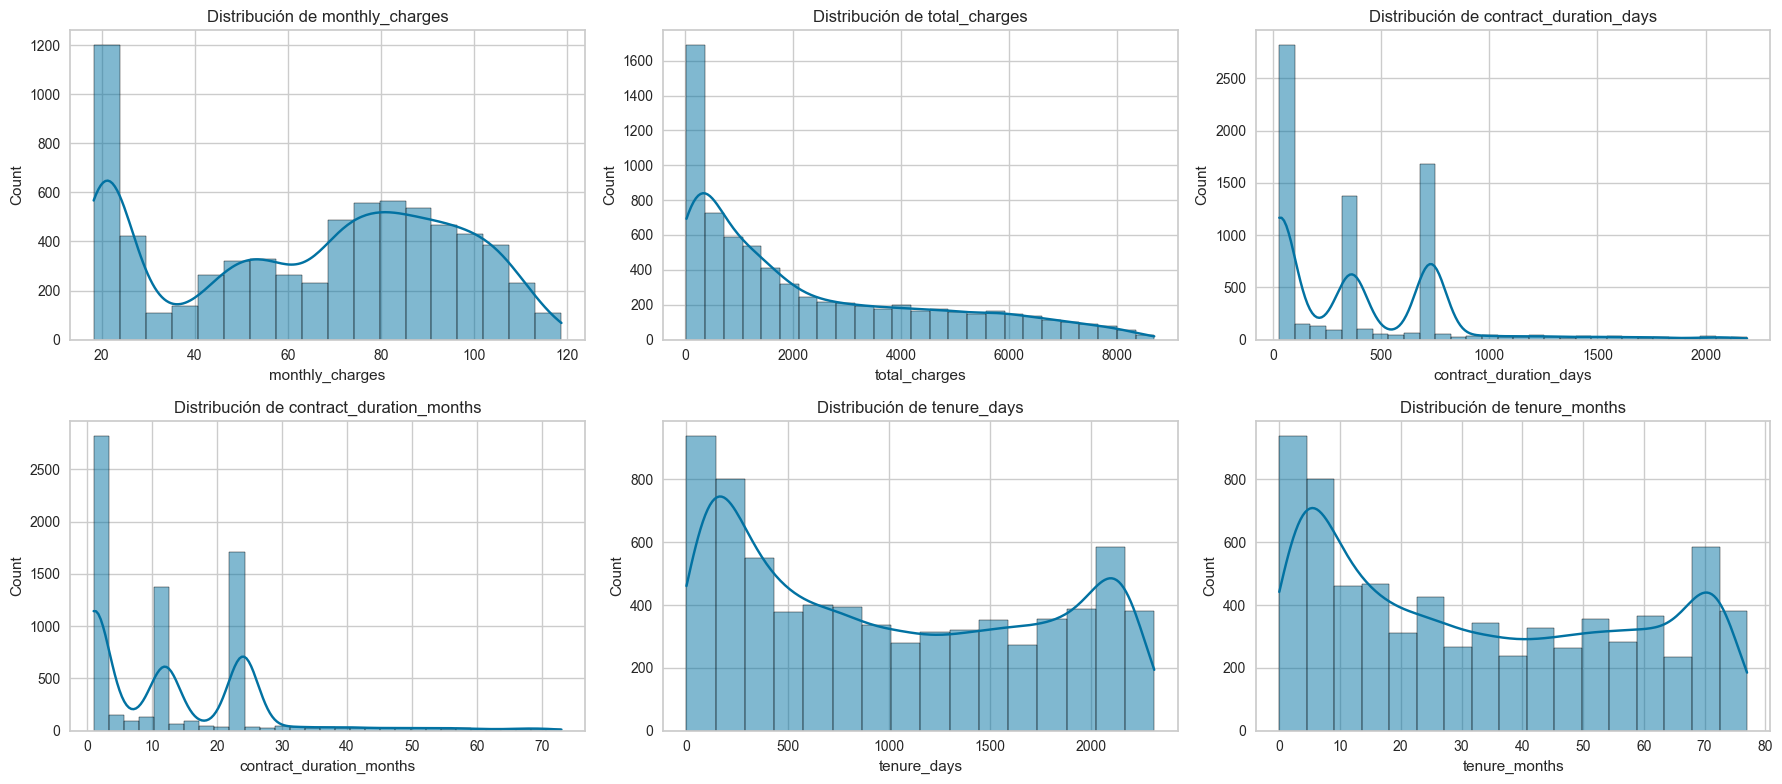

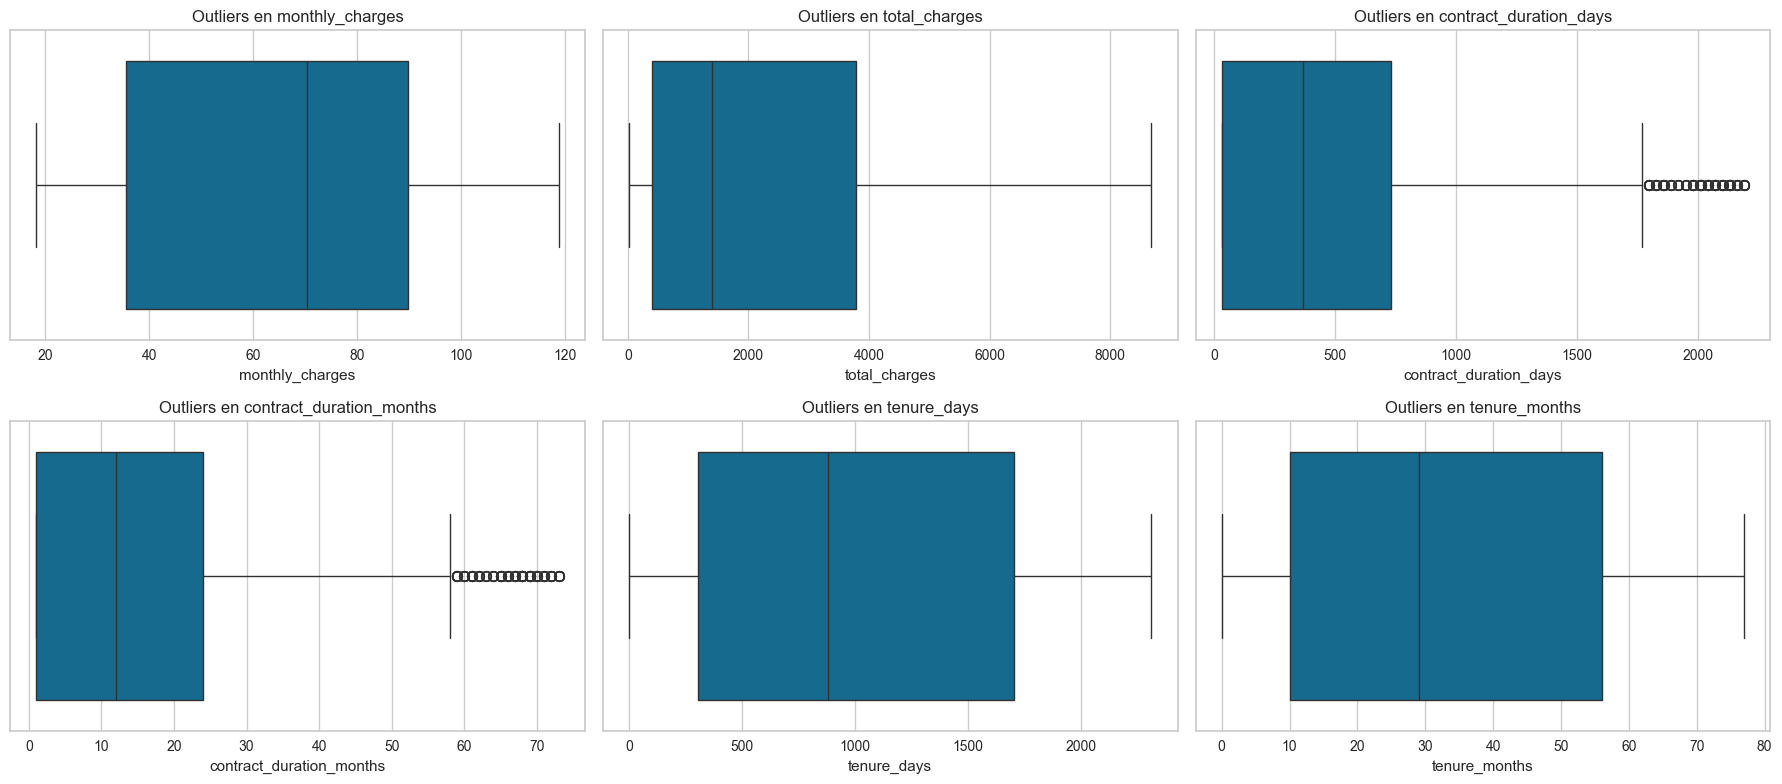

In [60]:
# Definimos las variables numéricas
num_cols = ["monthly_charges","total_charges","contract_duration_days",
            "contract_duration_months","tenure_days","tenure_months"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
axes = axes.flatten()
for ax, col in zip(axes, num_cols):
    sns.histplot(df_all[col], kde=True, ax=ax)
    ax.set_title(f"Distribución de {col}")
plt.tight_layout()
plt.show()

# Boxplots para outliers
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
axes = axes.flatten()
for ax, col in zip(axes, num_cols):
    sns.boxplot(x=df_all[col], ax=ax)
    ax.set_title(f"Outliers en {col}")
plt.tight_layout()
plt.show()

En la primer imágen de histogramas para las variables numéricas, podemos detectar colas largas (long tails) en las variables 'total_charges', 'contract_duration_days' y 'contract_duration_months', lo cual indica que hay una distribución sesgada hacia la derecha; es decir, que la mayoría de los clientes tienen valores bajos o medios, pero hay algunos pocos con valores mucho más altos que extienden las colas.

- "La variable 'total_charges' presenta una distribución sesgada hacia la derecha, con una cola larga que indica la presencia de clientes con cargos acumulados significativamente altos."
- "Las variables 'contract_duration_days' y 'contract_duration_months' muestran colas largas, lo que sugiere que aunque la mayoría de los contratos son de corta duración, existe un grupo reducido con contratos mucho más extensos."
- "La presencia de colas largas en estas variables podría influir en el análisis estadístico y en los modelos predictivos, por lo que se recomienda considerar transformaciones o técnicas robustas ante outliers."

En la segunda imágen de gráficos tipo "boxplots" las variables 'contract_duration_days' y 'contract_duration_months' presentan valores atípicos (outliers) en el extremo superior, lo que sugiere la existencia de contratos excepcionalmente largo. Estos outliers podrían afectar la interpretación estadística y deben consederarse en el modelado.
Las variables 'tenure_days' y 'tenure_months' no presentan outliers visibles, pero su distribución muestra concentración en rangos bajos, lo que podría indicar una alta proporción de clientes nuevos. Esta característica es relevante para el análisis de churn, ya que la permanencia suele estar asociada a la fidelidad del cliente.

En resumen, las variables numéricas muestran distribuciones sesgadas en varios casos ('total_charges', 'contract_duration_days', 'contract_duration_months') y presencia de outliers en las duraciones de contrato. Esto sugiere una heterogeneidad importante en el comportamiento de los clientes, que deberá ser considerada en el análisis predictivo y segmentación.

#### Categóricas y proporciones de servicios

Ahora vamos a revisar las variables categóricas que se refieren a los servicios básicos y extras proporcionados por la empresa Interconnect; así como las características personales de los clientes.
Vamos a dividirlas en tres secciones para un mejor análisis:

1. Variables categóricas de Tipo de contrato, Método de pago y Servicio de Internet
2. Variables personales (facturación y relación familiar)
3. Variables de servicios extra contratados

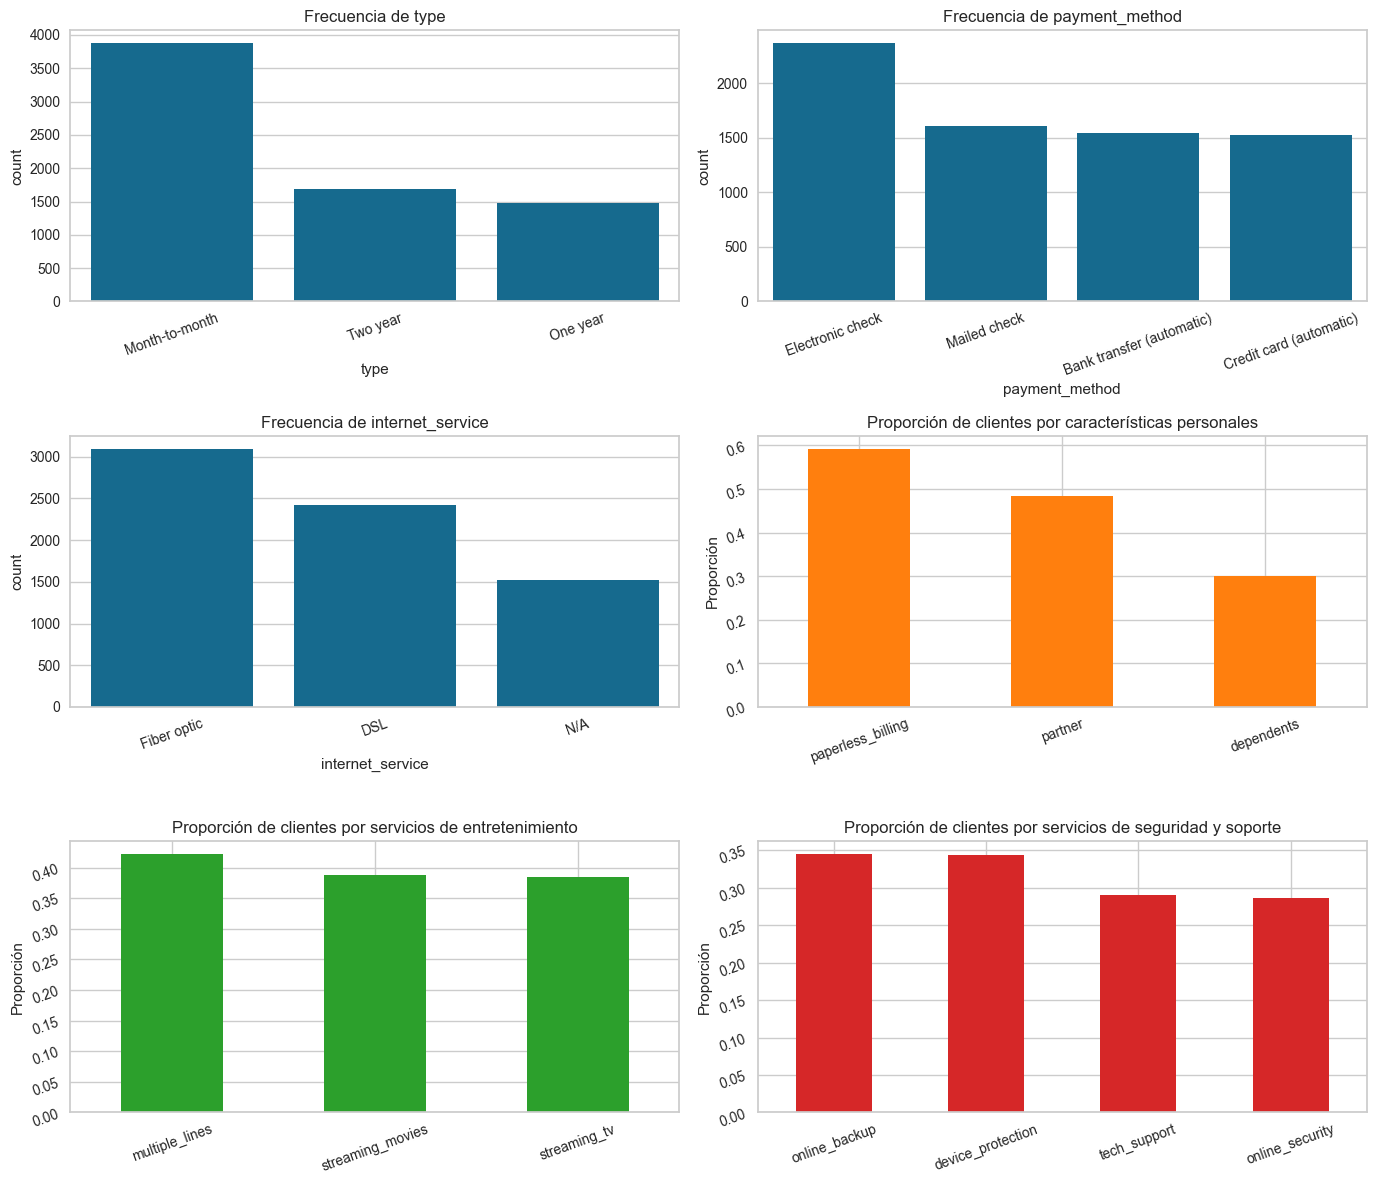

In [61]:
# Definir columnas
cat_cols = ["type","payment_method","internet_service"]
bool_personal_cols = ["paperless_billing", "partner", "dependents"]
bool_entertainment_cols = ["streaming_tv","streaming_movies","multiple_lines"]
bool_security_cols = ["online_security","online_backup","device_protection","tech_support"]

# Crear figura con 3x2 subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()  # para iterar fácilmente

# 1. Variables categóricas
for i, col in enumerate(cat_cols):
    order = df_all[col].value_counts().index
    sns.countplot(x=df_all[col], order=order, ax=axes[i])
    axes[i].set_title(f"Frecuencia de {col}")
    axes[i].tick_params(axis='x', rotation=20)

# 2. Variables personales
prop_personal = df_all[bool_personal_cols].mean().sort_values(ascending=False)
prop_personal.plot(kind="bar", ax=axes[3], color="tab:orange")
axes[3].set_title("Proporción de clientes por características personales")
axes[3].tick_params(rotation=20)
axes[3].set_ylabel("Proporción")

# 3. Variables de servicios de entretenimiento
prop_service = df_all[bool_entertainment_cols].mean().sort_values(ascending=False)
prop_service.plot(kind="bar", ax=axes[4], color="tab:green")
axes[4].set_title("Proporción de clientes por servicios de entretenimiento")
axes[4].tick_params(rotation=20)
axes[4].set_ylabel("Proporción")

# 4. Variables de servicios de seguridad y soporte
prop_security = df_all[bool_security_cols].mean().sort_values(ascending=False)
prop_security.plot(kind="bar", ax=axes[5], color="tab:red")
axes[5].set_title("Proporción de clientes por servicios de seguridad y soporte")
axes[5].tick_params(rotation=20)
axes[5].set_ylabel("Proporción")

plt.tight_layout()
plt.show()

1. Variables categóricas (tipo de contrato, método de pago, servicio de internet)

    La mayoría de los clientes tienen contratos de tipo mensual('Month-to-month'), utiliza el método de pago por cheque electrónico ('Electronic check') y prefieren el servicio de internet por fibra óptica ('Fiber optic'). Estas categorías predominantes pueden influir en el comportamiento de cancelación y en la rentabilidad del cliente.

2. Características personales (facturación y relación familiar)

    La facturación digital ('paperless_billing') es la característica personal más común entre los clientes, mientras que una menor proporción reporta tener pareja o dependientes. 

3. Servicios contratados (servicios adicionales booleanos)

    El servicio adicional más contratado es el de múltiples líneas ('multiple_lines'), seguido por opciones de entretenimiento como 'streaming_movies' y 'streaming_tv'. 
    En contraste, los servicios de soporte y seguridad como 'tech_support' y 'online_security' presentan menor adopción, lo que podría estar vinculado a una mayor tasa de cancelación.

Estos patrones de contratación y características personales ofrecen una base sólida para identificar segmentos de clientes y analizar su relación con la cancelación del servicio (churn).


#### Tendencias temporales

Se generó una gráfica de líneas con contratos iniciados (verde) y finalizados (rojo) por mes


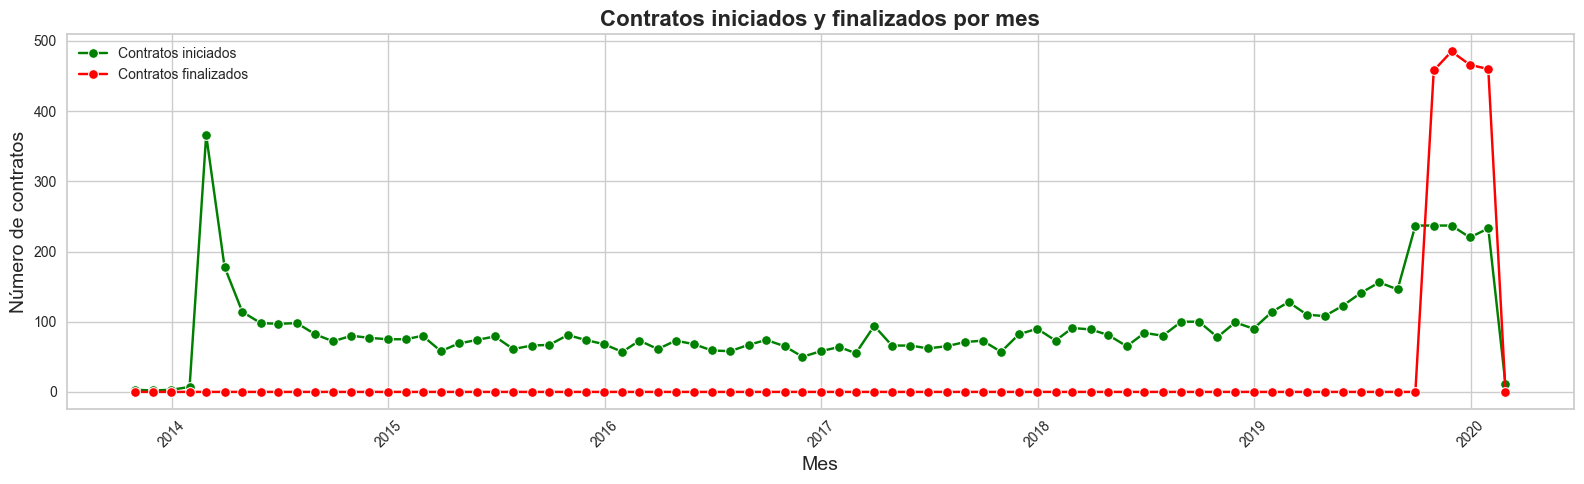

In [62]:
# Generamos una copia
df_date = df_all.copy()

# Inicio de contratos por mes
started_contracts = df_date.set_index('begin_date').resample('M').size().reset_index()
started_contracts.columns = ['date', 'started_contracts']

# Fin de contratos por mes (churn)
ended_contracts = df_date[df_date['churn'] == 1].set_index('end_date').resample('M').size().reset_index()
ended_contracts.columns = ['date', 'ended_contracts']

# Juntamos ambas series
timeline = pd.merge(started_contracts, ended_contracts, on='date', how='outer').fillna(0)

# Graficamos
sns.set_style("whitegrid")
plt.figure(figsize=(16, 5))
sns.lineplot(data=timeline, x='date', y='started_contracts', label='Contratos iniciados', color='green', marker='o')
sns.lineplot(data=timeline, x='date', y='ended_contracts', label='Contratos finalizados', color='red', marker='o')
plt.title("Contratos iniciados y finalizados por mes", fontsize=16, fontweight='bold')
plt.xlabel("Mes", fontsize=14)
plt.ylabel("Número de contratos", fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

print("Se generó una gráfica de líneas con contratos iniciados (verde) y finalizados (rojo) por mes")

La gráfica muestra:

- Pico inicial de altas en 2014, seguido de una estabilización entre los años 2015 y 2019 y una ligera alza para 2020 nuevamente.
- Sin embargo, hay un incremento de bajas hacia finales de 2019, lo que podría indicar un problema de retención o cambios en la oferta.
- Ambas curvas permiten comparar visualmente el flujo de clientes, útil para detectar estacionalidad, campañas efectivas o periodos críticos.

Esta tendencia sugiere la necesidad de revisar estrategias de retención en ese periodo, especialmente para clientes con contratos mensuales o sin servicios complementarios.

NOTA: no se cuenta con registros de cancelación antes de 2020.

#### Tendencias de tenencia (tenure)

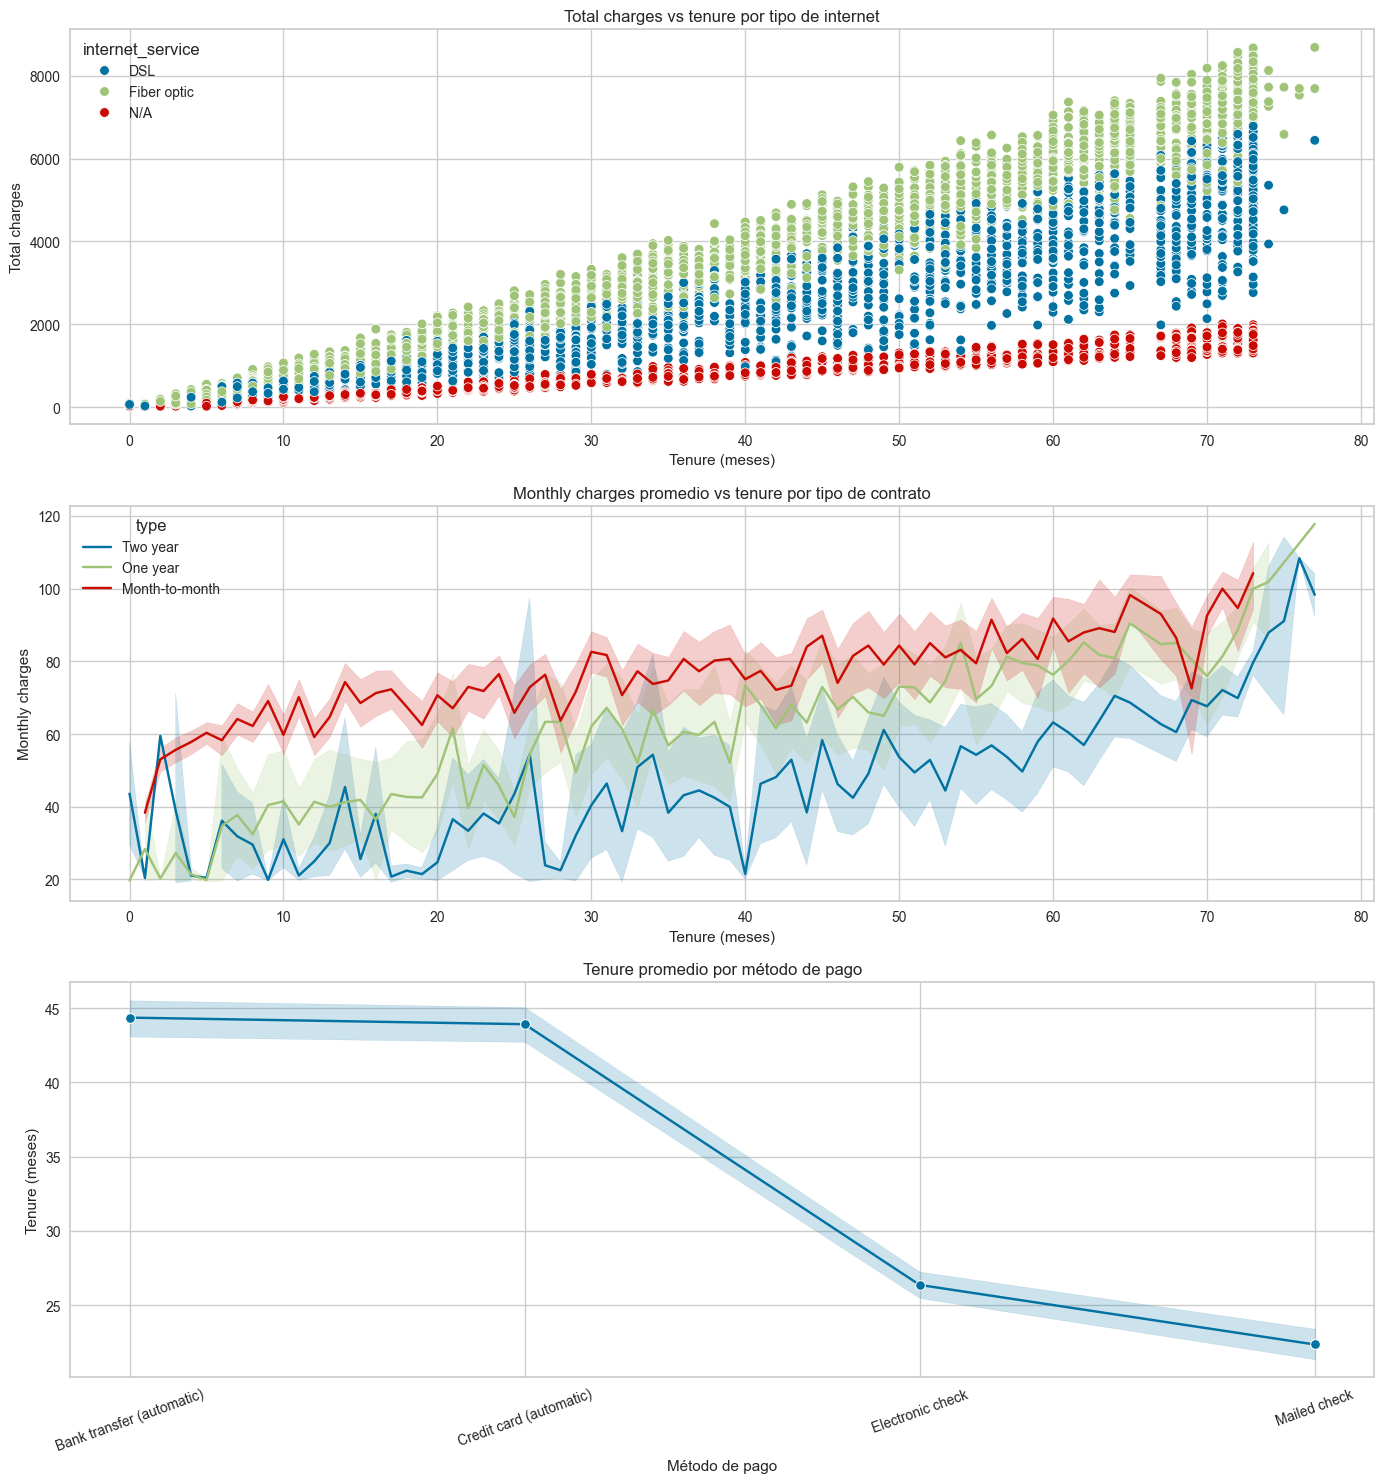

In [63]:
# Set style
sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(14, 15))

# 1. Scatter plot: total_charges vs tenure_months by internet_service
sns.scatterplot(data=df_all, x="tenure_months", y="total_charges", hue="internet_service", ax=axes[0])
axes[0].set_title("Total charges vs tenure por tipo de internet")
axes[0].set_xlabel("Tenure (meses)")
axes[0].set_ylabel("Total charges")

# 2. Line plot: average monthly_charges vs tenure_months by contract type
sns.lineplot(data=df_all, x="tenure_months", y="monthly_charges", hue="type", estimator="mean", ax=axes[1])
axes[1].set_title("Monthly charges promedio vs tenure por tipo de contrato")
axes[1].set_xlabel("Tenure (meses)")
axes[1].set_ylabel("Monthly charges")

# 3. Line plot: average tenure_months by payment_method
tenure_by_payment = df_all.groupby("payment_method")["tenure_months"].mean().sort_values(ascending=False).index
df_sorted = df_all.set_index("payment_method").loc[tenure_by_payment].reset_index()
sns.lineplot(data=df_sorted, x="payment_method", y="tenure_months", estimator="mean", marker="o")
axes[2].set_title("Tenure promedio por método de pago")
axes[2].set_xlabel("Método de pago")
axes[2].set_ylabel("Tenure (meses)")
axes[2].tick_params(axis='x', rotation=20)

plt.tight_layout()
# plt.show()

Las gráficas de tenencia revelan patrones importantes: los clientes con contratos mensuales y pagos por cheque electrónico tienden a tener menor permanencia y mayores cargos mensuales. En contraste, los contratos de largo plazo y pagos automáticos están asociados a mayor fidelidad. Además, el tipo de servicio de internet influye en el total acumulado, siendo la fibra óptica el más costoso.

La tenencia promedio varía significativamente según el método de pago. Los clientes que utilizan pagos automáticos (transferencia o tarjeta) presentan mayor permanencia, mientras que aquellos que pagan con cheque electrónico tienden a cancelar más rápido. Este hallazgo sugiere que los métodos de pago pueden ser un indicador útil para segmentar clientes y anticipar churn.

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Perfecto, el EDA tiene un buen análisis que ayuda a entender mejor los datos a utilizar para los entrenamientos
</div>

#### Churn: distribución y relaciones clave

##### Distribución de churn con porcentajes y anotaciones

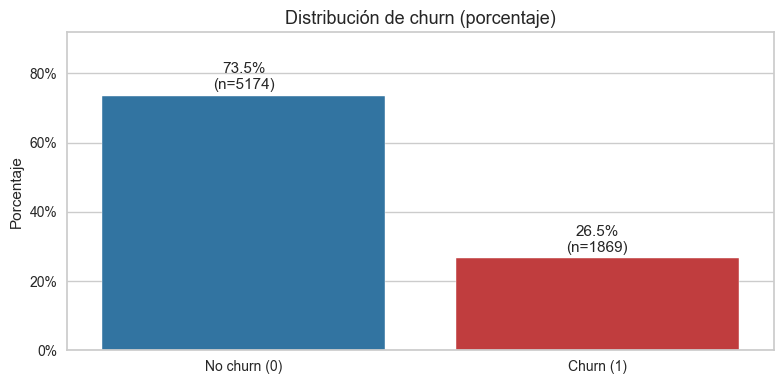

Tasa global de churn: 26.54%


In [64]:
# Asegurar que churn sea binario (0/1)
churn = df_all["churn"].astype(int)

# Calcular proporciones y conteos
counts = churn.value_counts().sort_index()
props = (counts / counts.sum()) * 100

# Mapeo de etiquetas
labels = ["No churn (0)", "Churn (1)"]

# Gráfica
plt.figure(figsize=(8,4))
ax = sns.barplot(x=labels, y=props.values, palette=["tab:blue", "tab:red"])

# Formato de eje Y a porcentaje
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}%"))
plt.title("Distribución de churn (porcentaje)", fontsize=13)
plt.xlabel("")
plt.ylabel("Porcentaje")

# Anotar porcentajes y conteos encima de las barras
for i, (p, c) in enumerate(zip(props.values, counts.values)):
    ax.text(i, p + 1, f"{p:.1f}%\n(n={c})", ha="center", va="bottom", fontsize=11)

plt.ylim(0, max(props.values) * 1.25)
plt.tight_layout()
plt.show()

# Mostrar tasa global de churn (texto)
churn_rate = churn.mean()
print(f"Tasa global de churn: {churn_rate:.2%}")

La gráfica muestra que el 26.5% de los clientes han cancelado el servicio (churn), mientras que el 73.5% permanecen activos o leales.

- Churn rate = 26.5% -> proporción de clientes que se han dado de baja.
- Retención = 73.5% -> proporción de clientes que siguen contratando el servicio.

La tasa global de churn asciende a 26.5%, lo que indica que aproximadamente uno de cada cuatro clientes ha cancelado el servicio. El 73.5% restante representa la base de clientes leales, cuya permanencia puede estar influenciada por el tipo de contrato, método de pago y servicios adicionales contratados.

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Excelente, este es un punto muy importante a considerar al momento de realizar los entrenamientos y la elección del algoritmo a entrenar para generar tu modelo.

El balance de clases en un proyecto de clasificación es un punto importante ya que de esto depende cómo se va a ajustar el modelo y que parámetros se pueden cambiar para garantizar un correcto desempeño.
</div>

##### Tasas de churn por tipo de contrato, método de pago y servicio de internet

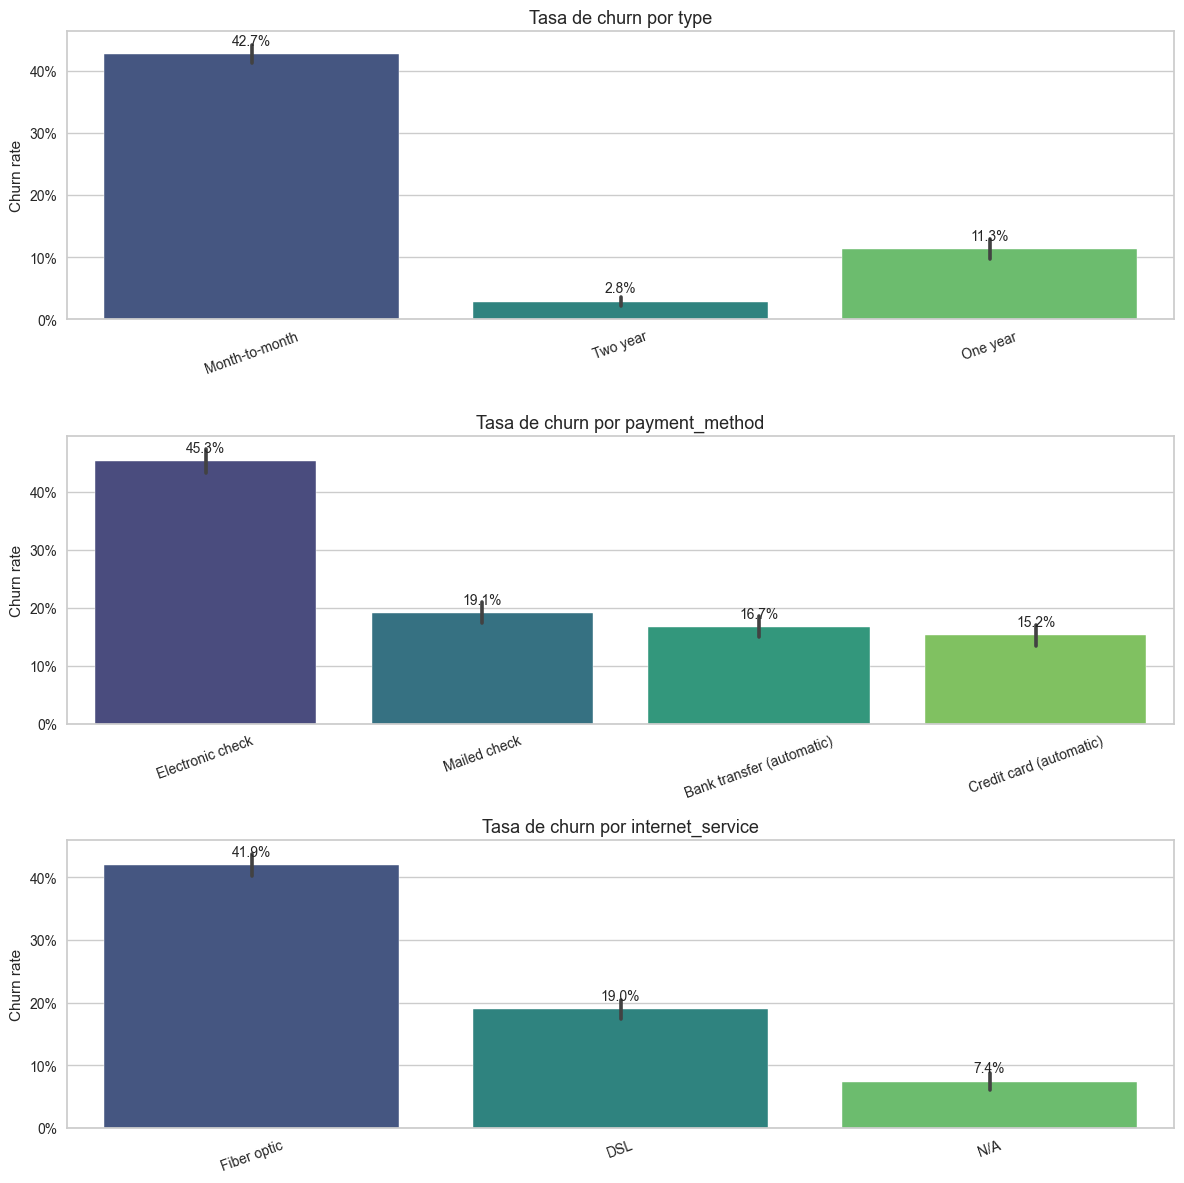

In [65]:
# Caolumnas o variables categóricas
cat_cols = ["type", "payment_method", "internet_service"]

# Preparar figura 3x1
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
palette = "viridis"

for i, col in enumerate(cat_cols):
    # Orden por frecuencia para mayor legibilidad
    order = df_all[col].value_counts().index

    # Barplot con tasa de churn promedio (mean de 0/1)
    ax = sns.barplot(
        x=col, y="churn", data=df_all.assign(churn=df_all["churn"].astype(int)),
        order=order, estimator=np.mean, ci=95, ax=axes[i], palette=palette
    )

    # Título y ejes
    axes[i].set_title(f"Tasa de churn por {col}", fontsize=13)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Churn rate")

    # Rotar categorías si es necesario
    axes[i].tick_params(axis="x", rotation=20)

    # Formato de porcentaje en eje Y
    axes[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))

    # Anotar porcentaje encima de cada barra
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width()/2, height + 0.01,
            f"{height:.1%}", ha="center", va="bottom", fontsize=10
        )

plt.tight_layout()
plt.show()

Las gráficas del panel muestran con claridad que el churn se concentra en tres segmentos clave:

1. Tipo de contrato: Month-to-month
    - Tasa de churn: 42.7%
    - Son contratos sin compromiso, lo que facilita la cancelación.

2. Método de pago: Electronic check
    - Tasa de churn: 45.2%
    - Este método suele estar asociado a menor fidelidad y mayor riesgo de cancelación.

3. Servicio de internet: Fiber optic
    - Tasa de churn: 41.6%
    - Aunque es el servicio más popular, también muestra mayor sensibilidad al precio o a la calidad del servicio.

El análisis de churn por categorías revela que los clientes con contratos mensuales, que pagan mediante cheque electrónico y que utilizan el servicio de fibra óptica presentan las tasas de cancelación más elevadas. Estos segmentos representan focos críticos para estrategias de retención, ya que combinan flexibilidad contractual con métodos de pago menos comprometidos y servicios de alto costo.

##### Tasas de churn por cada servicio contratado

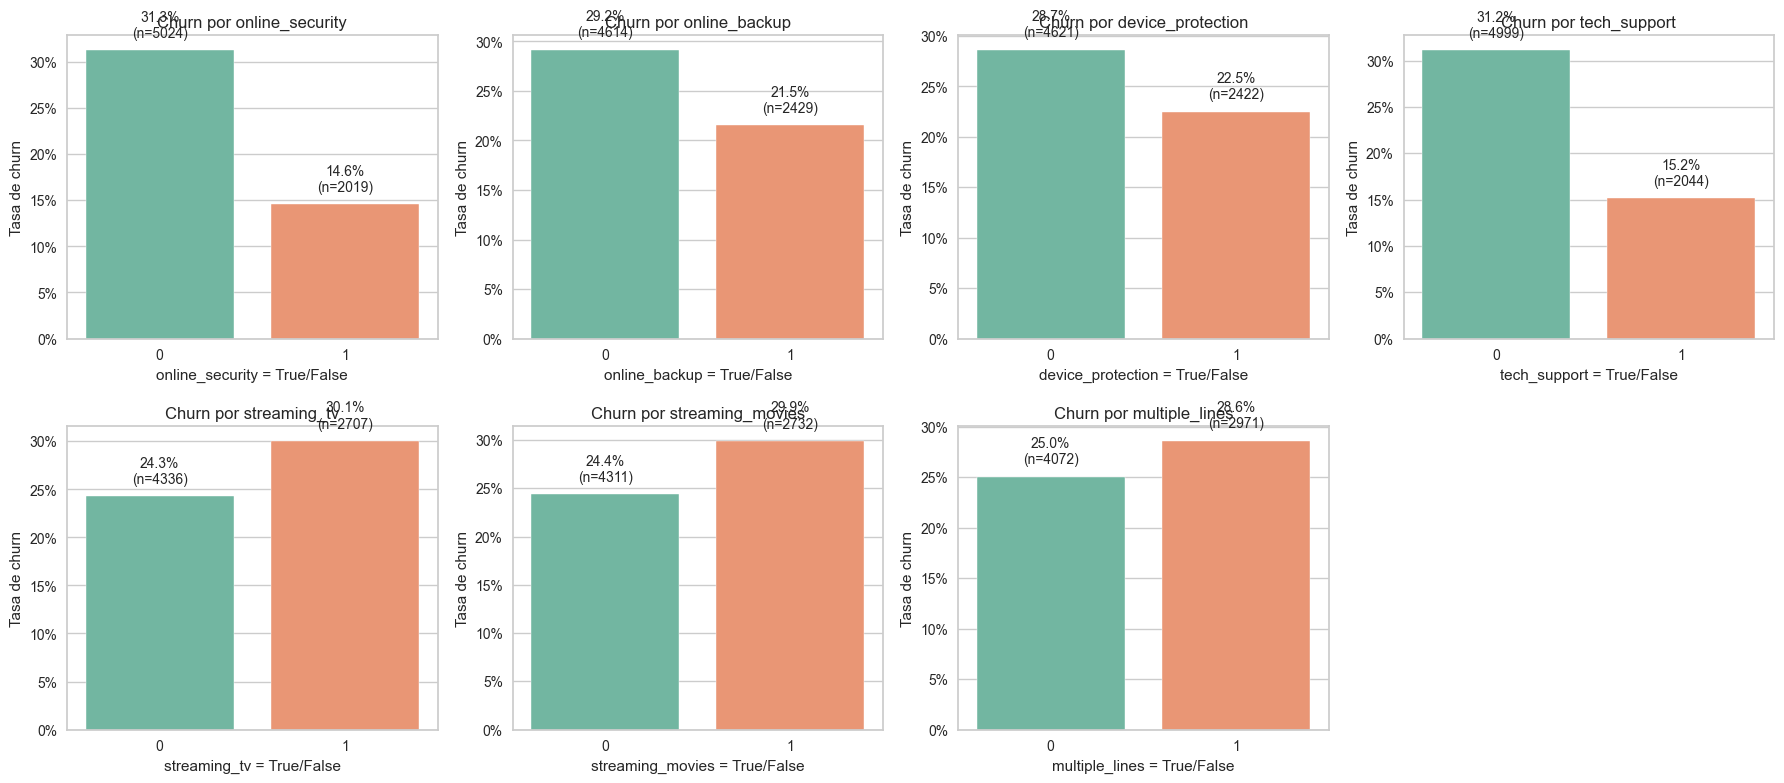

In [66]:
# Variables de servicio booleanas
bool_service_cols = [
    "online_security", "online_backup", "device_protection", "tech_support",
    "streaming_tv", "streaming_movies", "multiple_lines"
]

# Preparamos un panel 2x4 para subplots
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(bool_service_cols):
    # Group by de servicios y  cálculo de la taza de churn
    churn_rates = df_all.groupby(col)["churn"].mean().sort_index()
    counts = df_all[col].value_counts().sort_index()

    # Gráficas
    ax = sns.barplot(x=churn_rates.index.astype(str), y=churn_rates.values, ax=axes[i], palette="Set2")
    ax.set_title(f"Churn por {col}")
    ax.set_xlabel(f"{col} = True/False")
    ax.set_ylabel("Tasa de churn")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))

    # Leyendas en barras
    for j, (rate, count) in enumerate(zip(churn_rates.values, counts.values)):
        ax.text(j, rate + 0.01, f"{rate:.1%}\n(n={count})", ha="center", va="bottom", fontsize=10)

# Último subplot vacío
axes[-1].axis("off")

plt.tight_layout()

Principales hallazgos del panel

A) Servicios con menor churn cuando están contratados:

- online_security, tech_support, y device_protection muestran menor tasa de churn en clientes que los tienen activos, lo que sugiere que estos servicios contribuyen a la retención.

B) Servicios con menor impacto o comportamiento mixto:

- streaming_tv, streaming_movies, y multiple_lines tienen tasas de churn similares entre clientes que los tienen y los que no, lo que indica que su efecto en la fidelidad es menos claro.

C) Clientes sin servicios clave:

- En casi todos los casos, los clientes que no contratan servicios de soporte o seguridad tienen mayor churn, lo que refuerza la idea de que estos servicios agregan valor percibido.

El análisis de churn por servicios contratados revela que los clientes que cuentan con servicios de seguridad ('online_security'), soporte técnico ('tech_support') y protección de dispositivos ('device_protection') presentan tasas de cancelación significativamente menores. Estos servicios parecen actuar como factores de retención, mientras que los servicios de entretenimiento y líneas múltiples muestran un impacto menos consistente. Se recomienda fomentar la adopción de servicios de soporte en segmentos de alto riesgo.

##### Análisis de churn por variables numéricas

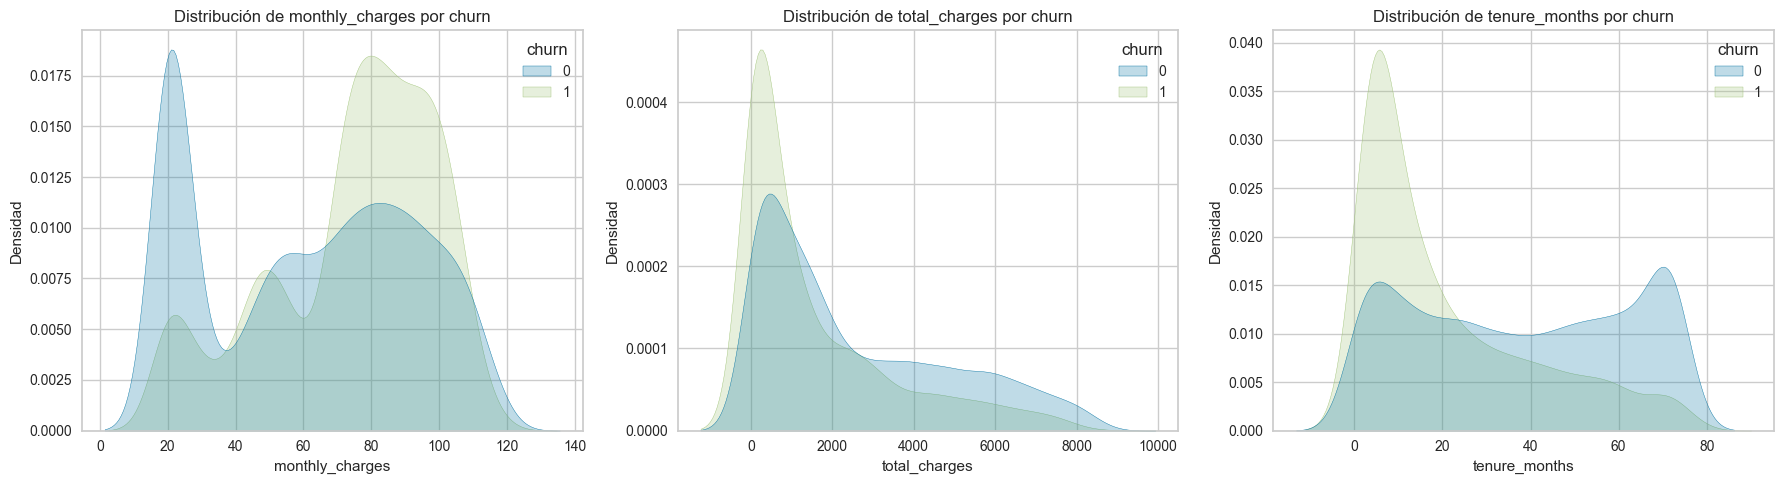

In [67]:
# Variables numéricas
num_cols = ["monthly_charges","total_charges","tenure_months"]

# Crear panel 1x3 con distribuciones comparadas
fig, axes = plt.subplots(1, 3, figsize=(18,5))

for i, col in enumerate(num_cols):
    sns.kdeplot(data=df_all, x=col, hue="churn", common_norm=False, fill=True, ax=axes[i])
    axes[i].set_title(f"Distribución de {col} por churn")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Densidad")

plt.tight_layout()
plt.show()

A) Monthly charges:

- Clientes con churn suelen concentrarse en valores más altos de cargos mensuales.
- Esto indica sensibilidad al precio.

B) Total charges:

- Clientes leales acumulan cargos más altos (porque permanecen más tiempo).
- Los que churnearon tienden a tener valores bajos -> cancelaron pronto.

C) Tenure months:
- Clientes con baja tenencia (<12 meses) muestran mayor churn.
- Los clientes de largo plazo son más estables.

El análisis de churn por variables numéricas revela que los clientes con cargos mensuales más altos y menor tenencia presentan mayor probabilidad de cancelar el servicio. En contraste, los clientes con cargos acumulados elevados y mayor permanencia muestran una mayor fidelidad. Estos hallazgos sugieren que la sensibilidad al precio y la falta de antigüedad son factores clave en la cancelación.

#### Correlaciones y selección de señales

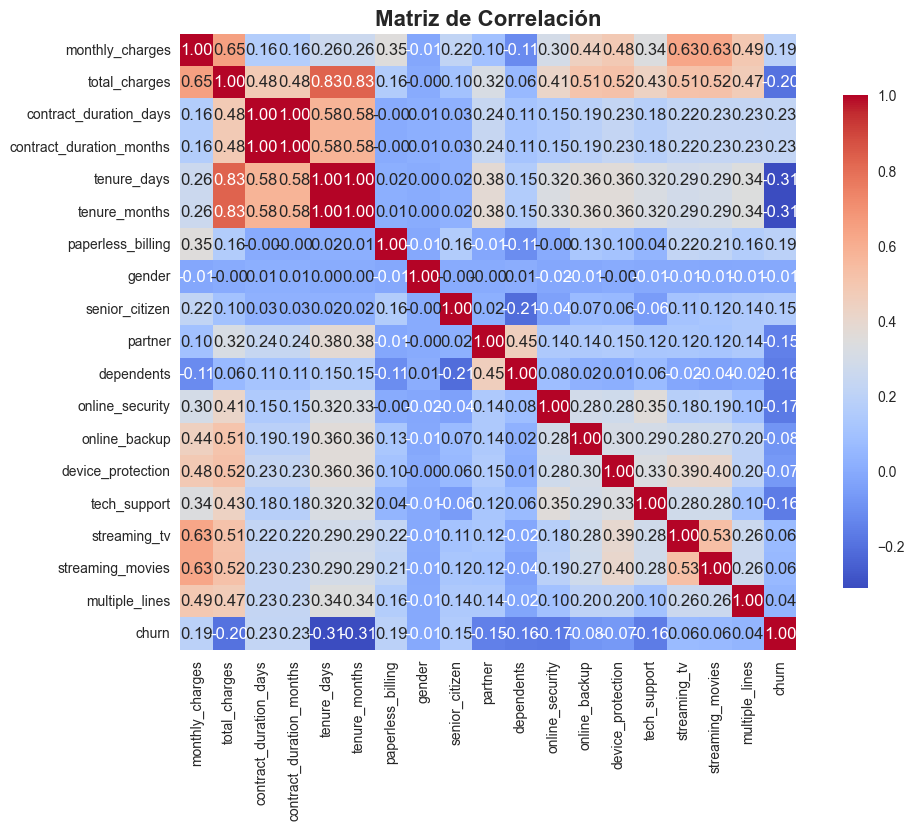

In [68]:
# Graficamos una matriz de correlación usando Seaborn
plt.figure(figsize=(12, 8))

# Seleccionamos solo las columnas numéricas para la correlación
numeric_cols = df_all.select_dtypes(include=[np.number])

# Calculamos la matriz de correlación
correlation_matrix = numeric_cols.corr()

# Creamos un mapa de calor de la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación', fontsize=16, fontweight='bold')
plt.show()

- Colores rojos (igual a 1): Correlaciones positivas fuertes. 
    'tenure_months' (antigüedad) y 'total_charges' (cargos totales) están altamente correlacionadas (0.83), lo que significa que clientes veteranos tienden a tener cargos totales más altos.

- Colores azules (cerca de -1): Correlaciones negativas. 
    'churn' (rotación) tiene una correlación negativa moderada con 'tenure_months' (-0.35), indicando que clientes nuevos churn más.

- Colores neutros (cerca de 0): Poca o ninguna relación. 
    'gender' (género) no se correlaciona mucho con otras variables.

- Insights clave: Variables como 'monthly_charges' y 'total_charges' están relacionadas (0.65), pero 'churn' tiene correlaciones bajas con la mayoría, sugiriendo que otras variables (como antigüedad) son mejores predictores.

La matriz de correlación revela relaciones fuertes entre variables de duración (tenure, contract_duration) y cargos acumulados (total_charges), lo cual es esperable dado que los clientes que permanecen más tiempo generan más ingresos. En contraste, variables como gender o multiple_lines muestran baja correlación con otras métricas, lo que sugiere que su impacto en el comportamiento del cliente es limitado desde una perspectiva lineal.

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Perfecto! El análisis de correlación siempre llevalo de la mano del contexto de negocio ya que no siempre correlación va a significar causalidad y aquí es donde tu conocimiento del negocio es importante para tomar decisiones en base a estos datos.
</div>

## 4. Modelado de Datos

Una vez que hemos revisado todas las características, vamos a preparar los datos para el modelo de machine learning.

### 4.1 Definición de Target & Feature

En los modelos de machine learning, no son relevantes los ID's de clientes ni las fechas para el cálculo de predicciones.
Por lo que se eliminarán las columnas irrelevantes para el modelado (customer_id, begin_date, end_date) y se definieron las variables predictoras excluyendo explícitamente la variable objetivo (churn) para evitar fuga de información.

### 4.2 Codificación de Variables Categóricas

Se codificarán las variables categóricas mediante One-Hot Encoding, transformando las categorías en variables binarias para su uso en modelos predictivos.

- `Opción A` (pipeline general con OHE):
Aplicamos One-Hot-Encoding a todas las variables categóricas y usaremos este dataset únicamente para LogisticRegression, DecisionTree, RandomForest, LightGBM y XGBoost.

- `Opción B` (pipeline específico para CatBoost):
Mantienes una copia del dataset sin OHE y pasas directamente las columnas categóricas a CatBoostClassifier, que las maneja internamente.


### 4.3 Separación en Entrenamiento y Prueba

El dataset se dividió en entrenamiento (70%) y prueba (30%), manteniendo la proporción de clientes que cancelan y que permanecen.

### 4.4 Balance de Clases y Escalamiento

Se revisará el balance de clases y se aplicaron técnicas de muestreo para evitar sesgos. Además, se normalizarán las variables numéricas para mejorar la estabilidad de los modelos.

Si el churn es muy bajo (ej. <20%), se recomienda aplicar técnicas de balanceo:
- Oversampling: SMOTE
- Undersampling: reducción de la clase mayoritaria

Escalamiento de Features:

- Depende de la distribución:
    - StandardScaler: útil si las variables siguen distribución normal.
    - MinMaxScaler: útil para algoritmos sensibles a rangos (ej. redes neuronales).
    - RobustScaler: útil si hay outliers.
    - MaxAbsScaler: útil para datos dispersos y centrados en 0.

In [69]:
# ============================================
# 4.1 Definición de Target & Features
# ============================================

# Eliminamos columnas irrelevantes
df_model = df_all.drop(['customer_id', 'begin_date', 'end_date'], axis='columns')

# Definimos Target y Features
target_col = 'churn'
X = df_model.drop(columns=[target_col])
y = df_model[target_col]

# ============================================
# 4.2 Codificación de Variables Categóricas
# ============================================

# Columnas categóricas
categorical_cols = X.select_dtypes(include="object").columns

# Dataset con OHE (para LogisticRegression, Árboles, RF, XGB, LGBM)
X_ohe = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Dataset sin OHE (para CatBoost)
X_raw = X.copy()

# ============================================
# 4.3 Separación en Entrenamiento y Prueba
# ============================================

# Con OHE
X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(
    X_ohe, y, test_size=0.3, random_state=42, stratify=y
)

# Sin OHE (para CatBoost)
X_train_raw, X_test_raw, _, _ = train_test_split(
    X_raw, y, test_size=0.3, random_state=42, stratify=y
)

# ============================================
# 4.4 Balance de Clases y Escalamiento
# ============================================

# Revisar balance
print("Distribución de clases en y_train:")
print(y_train.value_counts(normalize=True))

# Escalamiento SOLO para LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_ohe)
X_test_scaled = scaler.transform(X_test_ohe)

# Nota:
# - LogisticRegression → usar X_train_scaled, X_test_scaled
# - Árboles, RF, XGB, LGBM → usar X_train_ohe, X_test_ohe (sin escalar)
# - CatBoost → usar X_train_raw, X_test_raw (sin OHE, sin escalar)

Distribución de clases en y_train:
churn
0    0.734686
1    0.265314
Name: proportion, dtype: float64


Índice de tu secuencia de Modelado
- 4.1 → Definición de Target & Features
- 4.2 → Codificación de Variables Categóricas (OHE vs Raw)
- 4.3 → Separación en Entrenamiento y Prueba (dos versiones: OHE y Raw)
- 4.4 → Balance de Clases y Escalamiento (solo aplica escalamiento para LogisticRegression)

Ahora se tienen tres variantes de datasets listos para cada tipo de modelo:
- X_train_scaled, X_test_scaled → LogisticRegression
- X_train_ohe, X_test_ohe → Árboles, RandomForest, XGB, LGBM
- X_train_raw, X_test_raw → CatBoost


### 4.5: Definición, Entrenamiento y Evaluación de Modelos

En esta sección nos apoyaremos de una herramienta para la comparación de varios modelos.

Fuente: https://pycaret.gitbook.io/docs/get-started/installation      (PyCaret 3.3.2 & python 3.11.7)

Se definieron múltiples modelos predictivos para comparar desempeño en la predicción de churn. La métrica principal de evaluación fue AUC-ROC, complementada con Recall, Precision y F1-score. Se establecieron criterios de negocio (SP) para clasificar el desempeño de los modelos. LogisticRegression se utilizó como modelo base interpretable, mientras que CatBoost aprovechó su capacidad nativa para manejar variables categóricas.

In [ ]:
# ============================================
# a) Definición de Modelos
# ============================================

# Diccionario de modelos
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=12345),
    "DecisionTree": DecisionTreeClassifier(random_state=12345),
    "RandomForest": RandomForestClassifier(random_state=12345),
    "LightGBM": LGBMClassifier(random_state=12345),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=12345),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=12345),
    "Dummy": DummyClassifier(strategy="most_frequent", random_state=12345)
}

# ============================================
# b) PyCaret como apoyo (benchmark rápido)
# ============================================

from pycaret.classification import setup, compare_models

clf_setup = setup(
    data=df_model,
    target='churn',
    session_id=12345,
    preprocess=True
)

best_model = compare_models()

# ============================================
# c) Función de Entrenamiento
# ============================================

def train_model(model, X_train, y_train):
    """Entrena un modelo con los datos de entrenamiento"""
    model.fit(X_train, y_train)
    return model

# ============================================
# d) Función de Evaluación del Error
# ============================================

def evaluate_model(model, X_test, y_test, model_name=""):
    """Evalúa un modelo con métricas de negocio y devuelve un diccionario"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    metrics = {
        "Model": model_name,
        "AUC-ROC": roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ConfusionMatrix": confusion_matrix(y_test, y_pred)
    }

    # Evaluación con SP
    auc = metrics["AUC-ROC"]
    if auc is not None:
        if auc < 0.75: metrics["SP"] = 0
        elif 0.75 <= auc < 0.81: metrics["SP"] = 4
        elif 0.81 <= auc < 0.85: metrics["SP"] = 4.5
        elif 0.85 <= auc < 0.87: metrics["SP"] = 5
        elif 0.87 <= auc < 0.88: metrics["SP"] = 5.5
        elif auc >= 0.88: metrics["SP"] = 6

    return metrics

# ============================================
# e) Ejecución para todos los modelos
# ============================================

results = []

# LogisticRegression → usar datos escalados
log_model = train_model(models["LogisticRegression"], X_train_scaled, y_train)
results.append(evaluate_model(log_model, X_test_scaled, y_test, "LogisticRegression"))

# Árboles, RF, XGB, LGBM, Dummy -> usamos OHE sin escalar
for name in ["DecisionTree", "RandomForest", "LightGBM", "XGBoost", "Dummy"]:
    mdl = train_model(models[name], X_train_ohe, y_train)
    results.append(evaluate_model(mdl, X_test_ohe, y_test, name))

# CatBoost -> usamos datos sin OHE, indicando columnas categóricas
categorical_cols = X_train_raw.select_dtypes(include="object").columns.tolist()
cat_model = CatBoostClassifier(verbose=0, random_state=12345)
cat_model.fit(X_train_raw, y_train, cat_features=categorical_cols)
results.append(evaluate_model(cat_model, X_test_raw, y_test, "CatBoost"))

# Convertir resultados a DataFrame para análisis
results_df = pd.DataFrame(results)
print(results_df[["Model","AUC-ROC","Recall","Precision","F1","SP"]])

,Description,Value
0,Session id,12345
1,Target,churn
2,Target type,Binary
3,Original data shape,"(7043, 22)"
4,Transformed data shape,"(7043, 29)"
5,Transformed train set shape,"(4930, 29)"
6,Transformed test set shape,"(2113, 29)"
7,Numeric features,18
8,Categorical features,3
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9986,0.9999,0.9954,0.9992,0.9973,0.9963,0.9964,4.4930
xgboost,Extreme Gradient Boosting,0.9984,0.9999,0.9946,0.9992,0.9969,0.9958,0.9958,0.1710
lightgbm,Light Gradient Boosting Machine,0.9984,0.9990,0.9954,0.9985,0.9969,0.9958,0.9958,0.6060
gbc,Gradient Boosting Classifier,0.9978,0.9999,0.9931,0.9985,0.9958,0.9943,0.9943,0.3990
ada,Ada Boost Classifier,0.9976,0.9997,0.9939,0.9970,0.9954,0.9937,0.9938,0.2080
rf,Random Forest Classifier,0.9970,0.9993,0.9885,1.0000,0.9942,0.9921,0.9922,0.2570
dt,Decision Tree Classifier,0.9968,0.9956,0.9931,0.9947,0.9939,0.9917,0.9917,0.0970
et,Extra Trees Classifier,0.9905,0.9983,0.9679,0.9961,0.9817,0.9752,0.9755,0.2740
knn,K Neighbors Classifier,0.9852,0.9969,0.9793,0.9655,0.9723,0.9622,0.9623,0.1160
lr,Logistic Regression,0.9570,0.9901,0.9029,0.9339,0.9175,0.8885,0.8892,2.4070


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 883
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265314 -> initscore=-1.018527
[LightGBM] [Info] Start training from score -1.018527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Observaciones clave de los resultados

1. Modelos de boosting y ensambles (CatBoost, XGBoost, LightGBM, Gradient Boosting, AdaBoost, Random Forest)

 - Todos alcanzan Accuracy > 99% y AUC ≈ 0.999.
 - Recall y Precision también son altísimos (>0.99).
 - Esto indica que el dataset es muy fácil de separar para estos algoritmos, probablemente porque las variables tienen una fuerte señal predictiva del churn.
 - CatBoost destaca con el mejor balance y métricas casi perfectas.

2. Modelos lineales (Logistic Regression, Ridge, LDA, SVM lineal)

 - Mucho más bajos: Accuracy entre 84–95%, AUC entre 0.92–0.99.
 - Recall de Logistic Regression ≈ 0.90, lo cual es aceptable pero no competitivo frente a los ensambles.
 - Esto confirma que el churn en tu dataset no es lineal y requiere modelos más complejos.

3. Modelos más simples (Naive Bayes, QDA, Dummy)

 - Accuracy < 80%, AUC < 0.90.
 - Recall alto en QDA (0.96) pero con Precision muy bajo (0.60).
 - Dummy apenas llega a 0.73 de Accuracy y AUC = 0.5 (aleatorio).
 - Sirven como referencia de “baseline trivial”.


<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Perfecto, muy bien realizadas las comparaciones entre los diferentes elementos. Quizá pensando en llevar los modelos a un entorno productivo también te recomendaría agregar una métrica de tiempo para ver cuanto tarda un modelo en predecir ya que esto también es importante cuando expones un modelo para ser utilizado con predicciones en tiempo real.
</div>

Interpretación para negocio

`AUC-ROC` (Métrica principal)

 - Todos los modelos de boosting superan 0.99, lo que según tu escala de SP equivale a 6 SP (máxima puntuación).
 - Logistic Regression queda en 0.99 -> 6 SP, pero con menor Recall (0.90).
 - Modelos simples como Naive Bayes y Dummy se quedan muy por debajo (SP = 0).

`Recall` (churn positivo)
 - CatBoost y LightGBM logran Recall ≈ 0.995 -> casi ningún cliente que se va queda sin detectar.
 - Logistic Regression baja a 0.90 -> más clientes “perdidos”.
 - Esto es crítico para negocio: los ensambles son más confiables para retención.

`Precision`
 - Random Forest tiene Precision = 1.0 -> todos los clientes que predice como “se va” realmente se van.
 - CatBoost y XGBoost también muy altos (>0.99).
 - Esto significa que las campañas de retención serían muy “limpias” (pocos falsos positivos).


Los modelos de boosting y ensambles (CatBoost, XGBoost, LightGBM) alcanzaron métricas casi perfectas (AUC-ROC ≈ 0.999, Recall > 0.99, Precision > 0.99), lo que indica una fuerte capacidad predictiva del dataset. Logistic Regression, aunque interpretable, mostró menor Recall (0.90), lo que implica que dejaría escapar más clientes en riesgo. Los modelos simples (Naive Bayes, QDA, Dummy) se utilizaron como referencia y confirmaron que el problema requiere algoritmos más complejos. Según los criterios de negocio (SP), los modelos de boosting obtuvieron la máxima puntuación (6 SP).

<div class="alert alert-block alert-success">
<b>Comentario general (1ra Iteración)</b> <a class=“tocSkip”></a>

¡**Buen trabajo con el desarrollo del proyecto Tom**!
    
Realizaste una muy buena exploración de tus datos y planteaste comentarios acertados de los resultados, las métricas utilizadas para tus modelos son las adecuadas,
    
Me gustaría dejarte algunas recomendaciones para que resaltes tu perfil profesional en el mundo laboral:
    
- **Exponer los modelos:** Puedes agregar más valor a tu perfil profesional exponiendo los modelos para que puedan ser utilizados en algún demo, esto puedes hacerlo con streamlit y en render.com cómo lo hiciste en un sprint anterior. Pero si quieres ir más allá también podrías investigar y hacerlo utilizando el framework de FastAPI.
- **Herramientas cloud:** Para demostrar un perfil más completo, también podrías utilizar algún servicio cloud cómo AWS y tratar de subir tus modelos entrenados ahí. No tienes que hacerlo a manera de experto, pero siempre es un plus tener conocimiento de estas herramientas.
- **Continúa aprendiendo y practicando:** La práctica hace al maestro, mientras más practiques más errores podrás solucionar y estarás más listo para afrontar problemas reales en un entorno laboral.
    
Saludos y felicidades!
</div>